# 5. Modeling

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Data Modeling](#5_Data_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Data](#5.4_Load_Data)
  * [5.5 Data Preprocessing](#5.5_Data_Preprocessing)
  * [5.6 Data Modeling](#5.6_Data_Modeling)
  * [5.7 Data Visualization](#5.7_Data_Visualization)

## 5.2 Introduction<a id='5.2_Introduction'></a>

In this section, automachine learning package will be applied to multiple time series. Due to limit of CPU of my computer, only 50 time series were selected to conduct automachine learning. THe package I use is mljar, free resource for automachine learning. It contains various ML models including dicision tree, linear regression, random forest, XGboost, LightGBM, Catboost, Neural Network, and ensemble. All the results, such as selected model, MAPE of test dataset, predictions are stored in dictionary "model_dict"

## 5.3 Imports<a id='5.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os

import math

from datetime import datetime, timedelta

import itertools
from itertools import chain, combinations

import random


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

from supervised.automl import AutoML
import pickle

import holidays
from prophet import Prophet


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 5.4 Load Data<a id='5.4_Load_Data'></a>

In [2]:
#load data
folder_path=os.path.join(os.getcwd(), 'Data')


#df_ts = pd.read_pickle(folder_path+'\\'+'df_ts_clean.pkl')  
df_ts = pd.read_csv(folder_path+'\\'+'df_ts_FNL.csv')  
df_ts.head()

,Date,Store,Dept,Weekly_Sales,Holiday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Year,Month,Week,Weekday,Season,Holiday_name,MarkDown_Tot
0,2/5/2010,1,1,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,0.0,211.096358,8.106,2010,2,5,4,1,non-Holiday,0.0
1,2/12/2010,1,1,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,0.0,211.242170,8.106,2010,2,6,4,1,Superbowl,0.0
2,2/19/2010,1,1,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,0.0,211.289143,8.106,2010,2,7,4,1,Washington’s Birthday,0.0
3,2/26/2010,1,1,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,0.0,211.319643,8.106,2010,2,8,4,1,non-Holiday,0.0
4,3/5/2010,1,1,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,0.0,211.350143,8.106,2010,3,9,4,1,non-Holiday,0.0


In [3]:
#group time series by [store and dept]
df_ts_group=df_ts.groupby(['Store','Dept'])

In [4]:
#store individual time series into dictionary
df_ts_dict={}
for key in df_ts_group.groups.keys():
    df_ts_ind=df_ts_group.get_group(key).set_index('Date')
    df_ts_dict[key]=df_ts_ind

In [5]:
df_ts_dict[(1,1)]

,Store,Dept,Weekly_Sales,Holiday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,Weekday,Season,Holiday_name,MarkDown_Tot
Date,,,,,,,,,,,,,,,,,,,,
2/5/2010,1,1,24924.50,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,2010,2,5,4,1,non-Holiday,0.00
2/12/2010,1,1,46039.49,True,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,2010,2,6,4,1,Superbowl,0.00
2/19/2010,1,1,41595.55,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,2010,2,7,4,1,Washington’s Birthday,0.00
2/26/2010,1,1,19403.54,False,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,2010,2,8,4,1,non-Holiday,0.00
3/5/2010,1,1,21827.90,False,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,2010,3,9,4,1,non-Holiday,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/23/2012,1,1,NaN,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,2012,11,47,4,4,Thanksgiving Day,76311.31
11/30/2012,1,1,NaN,False,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,2012,11,48,4,4,non-Holiday,13415.29
12/7/2012,1,1,NaN,False,64.12,3.198,6343.16,0.00,270.00,2928.90,10147.90,223.660021,6.573,2012,12,49,4,4,non-Holiday,19689.96


## 5.5 Data Preprocessing<a id='5.5_Data_Preprocessing'></a>

In [6]:
#create dummy variables for col 'Holiday_name'
def dummy_df(df):
    df=pd.get_dummies(df,columns=['Holiday_name'])
    return df

In [7]:
added_features=['Temperature', 'Fuel Price', 'MarkDown1', 'MarkDown2','MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment','Weekly Sales']

In [8]:
#create a function to prepare the dataset with lagged features:
def create_lagged_features(df,features,num_lags):
    
    transformed_df=df
    
    for col in features:
        for i in range(1, num_lags + 1):
            transformed_df[f"{col}_lag_{i}"] = transformed_df[col].shift(i)
    lag_col=[col for col in df.columns if 'lag' in col]
    #transformed_df.dropna(subset=lag_col,inplace=True)
    return transformed_df

In [9]:
added_features=['Temperature', 'Fuel Price', 'MarkDown1', 'MarkDown2','MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment','Weekly Sales']

In [10]:
#data preprocessing to generate new features including dummy features and lagged features
df_ts_transform={}

for key in df_ts_dict.keys():
    df_ts_ind=df_ts_dict[key]
    df_ts_ind_dummy=dummy_df(df_ts_ind)
    df_ts_ind_dummy.columns = df_ts_ind_dummy.columns.str.replace(r'[^a-zA-Z0-9]', ' ')
    df_dummy_lag=create_lagged_features(df_ts_ind_dummy,added_features,5)
    df_ts_transform[key]=df_dummy_lag
    
    
    

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp\ipykernel_15244\459725516.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\ygao10\AppData\Local\Temp

In [11]:
df_ts_transform[(1,3)].columns

Index(['Store', 'Dept', 'Weekly Sales', 'Holiday', 'Temperature', 'Fuel Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Year', 'Month', 'Week', 'Weekday', 'Season',
       'MarkDown Tot', 'Holiday name Birthday of Martin Luther King  Jr ',
       'Holiday name Christmas Day', 'Holiday name Columbus Day',
       'Holiday name Independence Day', 'Holiday name Labor Day',
       'Holiday name Memorial Day', 'Holiday name New Year s Day',
       'Holiday name Superbowl', 'Holiday name Thanksgiving Day',
       'Holiday name Veterans Day', 'Holiday name Washington s Birthday',
       'Holiday name non Holiday', 'Temperature_lag_1', 'Temperature_lag_2',
       'Temperature_lag_3', 'Temperature_lag_4', 'Temperature_lag_5',
       'Fuel Price_lag_1', 'Fuel Price_lag_2', 'Fuel Price_lag_3',
       'Fuel Price_lag_4', 'Fuel Price_lag_5', 'MarkDown1_lag_1',
       'MarkDown1_lag_2', 'MarkDown1_lag_3', 'MarkDown1_lag_4',
       'MarkDo

In [12]:
feature_list=df_ts_transform[(1,3)].columns
feature_list= [i for i in feature_list if i not in ('Store', 'Dept','Holiday','MarkDown Tot','Weekly Sales')]

In [13]:
feature_list

['Temperature',
 'Fuel Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Year',
 'Month',
 'Week',
 'Weekday',
 'Season',
 'Holiday name Birthday of Martin Luther King  Jr ',
 'Holiday name Christmas Day',
 'Holiday name Columbus Day',
 'Holiday name Independence Day',
 'Holiday name Labor Day',
 'Holiday name Memorial Day',
 'Holiday name New Year s Day',
 'Holiday name Superbowl',
 'Holiday name Thanksgiving Day',
 'Holiday name Veterans Day',
 'Holiday name Washington s Birthday',
 'Holiday name non Holiday',
 'Temperature_lag_1',
 'Temperature_lag_2',
 'Temperature_lag_3',
 'Temperature_lag_4',
 'Temperature_lag_5',
 'Fuel Price_lag_1',
 'Fuel Price_lag_2',
 'Fuel Price_lag_3',
 'Fuel Price_lag_4',
 'Fuel Price_lag_5',
 'MarkDown1_lag_1',
 'MarkDown1_lag_2',
 'MarkDown1_lag_3',
 'MarkDown1_lag_4',
 'MarkDown1_lag_5',
 'MarkDown2_lag_1',
 'MarkDown2_lag_2',
 'MarkDown2_lag_3',
 'MarkDown2_lag_4',
 'MarkDown2_lag_5',
 'MarkDown3_

## 5.6 Data Modeling<a id='5.6_Data_Modeling'></a>

In [14]:
from sklearn.linear_model import LinearRegression
#train the model with train test split
models_dict = {}
count=0
future_points=8
for key, df in df_ts_transform.items():
    if count>=50:
        break
    X_train,y_train=df.iloc[5:143][feature_list],df.iloc[5:143]['Weekly Sales']
    train_index=X_train.index
    
    #initialize the model
    
    automl = AutoML(mode='Perform', results_path=f'AutoML_results_{key}', eval_metric="mape",validation_strategy=
    {
    "validation_type": "split",
    "train_ratio": 0.8,
    "shuffle": False,
    "stratify": False,
    },total_time_limit=3600)
    
    
    
    automl.fit(X_train, y_train) 
    predictions=[]
    X_test=df.iloc[143:][feature_list]
    test_index=X_test.index
    for i in range(future_points):
        
        X_test_update=X_test.iloc[[i]]
        y_prediction=automl.predict(X_test_update)[0]
        predictions.append(y_prediction)
        
        if i<future_points-1:
        #get lag_1 value from prediction
            X_test.loc[X_test.index[i+1],'Weekly Sales_lag_1']=y_prediction
        
            for j in range(5,1,-1):
                X_test.loc[X_test.index[i+1],f'Weekly Sales_lag_{j}']=X_test.loc[X_test.index[i],f'Weekly Sales_lag_{j-1}']
    
        
    pred_results=pd.DataFrame({'Date':test_index,'predicted_value':predictions})
    #get validation results    
    folder_path=os.path.join(os.getcwd(),f'AutoML_results_{key}','leaderboard.csv')
    leaderboard=pd.read_csv(folder_path)
    # Sort the DataFrame by 'col2'
    df_sorted = leaderboard.sort_values(by='metric_value')
    # Get the value in 'name' col for the first row
    min_MAPE_folder= df_sorted.iloc[0]['name']
    # get value in 'metric_value' col 
    MAPE_validation= df_sorted.iloc[0]['metric_value']
    if 'Ensemble' in min_MAPE_folder:
        validation_folder=os.path.join(os.getcwd(),f'AutoML_results_{key}',min_MAPE_folder)
        validation_results=pd.read_csv(os.path.join(validation_folder,'predictions_ensemble.csv'),header=0)
        validation_results.rename(columns={'prediction':'predicted_value','target':'original_value'},inplace=True)
        validation_residuals=validation_results['predicted_value']-validation_results['original_value']
    else:
        validation_folder=os.path.join(os.getcwd(),f'AutoML_results_{key}',min_MAPE_folder)
        validation_results=pd.read_csv(os.path.join(validation_folder,'predictions_validation.csv'),header=0)
        validation_results.rename(columns={'prediction':'predicted_value','target':'original_value'},inplace=True)
        validation_residuals=validation_results['predicted_value']-validation_results['original_value']
    
    #store all the information in dictionary
    original_results=pd.DataFrame({'Date':train_index,'original_value':y_train})
    models_dict[key] = {
        'models':automl,
        'model_name':min_MAPE_folder,
        'val_results':validation_results,
        'val_MAPE':MAPE_validation,
        'val_residual':validation_residuals,
        'predicted_value':pred_results,
        'original_value':original_results
    }  
    count+=1

AutoML directory: AutoML_results_(1, 1)
The task is regression with evaluation metric mape
AutoML will use algorithms: ['Linear', 'Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_algorithms will try to check up to 1 model
1_Linear mape 16246362940731.348 trained in 8.29 seconds (1-sample predict time 0.0187 seconds)
* Step default_algorithms will try to check up to 5 models
2_Default_LightGBM mape 0.083399 trained in 0.79 seconds (1-sample predict time 0.002 seconds)
3_Default_Xgboost mape 0.091457 trained in 2.92 seconds (1-sample predict time 0.0105 seconds)
4_Default_CatBoost mape 0.236748 trained in 0.95 seconds (1-sample predict time 0.0201 seconds)
5_Default_NeuralNetwork mape 0.462601 trained in 0.5 seconds (1-sample pr

41_NeuralNetwork_SelectedFeatures mape 0.093412 trained in 0.61 seconds (1-sample predict time 0.0225 seconds)
42_CatBoost mape 0.116613 trained in 0.93 seconds (1-sample predict time 0.0 seconds)
43_CatBoost mape 0.118524 trained in 1.1 seconds (1-sample predict time 0.0 seconds)
44_NeuralNetwork mape 0.153611 trained in 0.75 seconds (1-sample predict time 0.0156 seconds)
* Step hill_climbing_2 will try to check up to 13 models
45_Xgboost_GoldenFeatures_SelectedFeatures mape 0.053283 trained in 0.7 seconds (1-sample predict time 0.002 seconds)
46_Xgboost_GoldenFeatures_SelectedFeatures mape 0.049944 trained in 0.76 seconds (1-sample predict time 0.0139 seconds)
47_CatBoost_SelectedFeatures mape 0.057213 trained in 0.59 seconds (1-sample predict time 0.0 seconds)
48_LightGBM mape 0.082135 trained in 1.02 seconds (1-sample predict time 0.002 seconds)
49_LightGBM mape 0.085814 trained in 1.13 seconds (1-sample predict time 0.01 seconds)
50_LightGBM mape 0.082135 trained in 1.03 seconds (

31_RandomForest mape 0.035927 trained in 1.85 seconds (1-sample predict time 0.0181 seconds)
32_RandomForest mape 0.032274 trained in 1.45 seconds (1-sample predict time 0.0156 seconds)
33_RandomForest_SelectedFeatures mape 0.031922 trained in 1.19 seconds (1-sample predict time 0.0156 seconds)
34_RandomForest_SelectedFeatures mape 0.030134 trained in 1.18 seconds (1-sample predict time 0.0101 seconds)
35_Xgboost_SelectedFeatures mape 0.034493 trained in 1.02 seconds (1-sample predict time 0.0101 seconds)
36_Xgboost_SelectedFeatures mape 0.03418 trained in 0.99 seconds (1-sample predict time 0.0 seconds)
37_LightGBM mape 0.034452 trained in 1.36 seconds (1-sample predict time 0.0101 seconds)
38_LightGBM mape 0.034452 trained in 1.43 seconds (1-sample predict time 0.0121 seconds)
39_Xgboost mape 0.035621 trained in 1.25 seconds (1-sample predict time 0.0101 seconds)
40_Xgboost mape 0.03449 trained in 1.16 seconds (1-sample predict time 0.0101 seconds)
41_LightGBM_SelectedFeatures mape 0

2_Default_LightGBM_GoldenFeatures_SelectedFeatures mape 0.131447 trained in 1.26 seconds (1-sample predict time 0.0015 seconds)
6_Default_RandomForest_GoldenFeatures_SelectedFeatures mape 0.166287 trained in 1.35 seconds (1-sample predict time 0.0157 seconds)
7_Xgboost_SelectedFeatures mape 0.212976 trained in 1.25 seconds (1-sample predict time 0.0 seconds)
4_Default_CatBoost_SelectedFeatures mape 0.125247 trained in 1.29 seconds (1-sample predict time 0.0 seconds)
5_Default_NeuralNetwork_SelectedFeatures mape 0.325589 trained in 1.15 seconds (1-sample predict time 0.0082 seconds)
* Step hill_climbing_1 will try to check up to 19 models
27_CatBoost_SelectedFeatures mape 0.136644 trained in 1.24 seconds (1-sample predict time 0.0 seconds)
28_CatBoost_SelectedFeatures mape 0.125096 trained in 1.3 seconds (1-sample predict time 0.0101 seconds)
29_LightGBM_GoldenFeatures_SelectedFeatures mape 0.131447 trained in 1.24 seconds (1-sample predict time 0.01 seconds)
30_LightGBM_GoldenFeatures_

2_Default_LightGBM_SelectedFeatures mape 0.036656 trained in 2.0 seconds (1-sample predict time 0.0 seconds)
9_Xgboost_SelectedFeatures mape 0.047016 trained in 1.77 seconds (1-sample predict time 0.0156 seconds)
20_RandomForest_SelectedFeatures mape 0.045011 trained in 1.65 seconds (1-sample predict time 0.0 seconds)
17_CatBoost_SelectedFeatures mape 0.04452 trained in 1.62 seconds (1-sample predict time 0.0 seconds)
5_Default_NeuralNetwork_SelectedFeatures mape 0.056799 trained in 1.51 seconds (1-sample predict time 0.0123 seconds)
* Step hill_climbing_1 will try to check up to 19 models
27_LightGBM_SelectedFeatures mape 0.036656 trained in 2.0 seconds (1-sample predict time 0.0156 seconds)
28_LightGBM_SelectedFeatures mape 0.036656 trained in 1.92 seconds (1-sample predict time 0.0 seconds)
29_LightGBM mape 0.039387 trained in 2.1 seconds (1-sample predict time 0.0201 seconds)
30_LightGBM mape 0.039387 trained in 2.35 seconds (1-sample predict time 0.0181 seconds)
31_Xgboost mape 0.

13_LightGBM_GoldenFeatures_SelectedFeatures mape 0.129218 trained in 1.87 seconds (1-sample predict time 0.0 seconds)
26_NeuralNetwork_SelectedFeatures mape 0.12297 trained in 1.76 seconds (1-sample predict time 0.0 seconds)
18_CatBoost_SelectedFeatures mape 0.100371 trained in 1.91 seconds (1-sample predict time 0.0 seconds)
20_RandomForest_SelectedFeatures mape 0.123997 trained in 1.93 seconds (1-sample predict time 0.0156 seconds)
9_Xgboost_SelectedFeatures mape 0.30451 trained in 1.82 seconds (1-sample predict time 0.007 seconds)
* Step hill_climbing_1 will try to check up to 17 models
27_CatBoost_SelectedFeatures mape 0.106299 trained in 1.86 seconds (1-sample predict time 0.0102 seconds)
28_CatBoost_SelectedFeatures mape 0.09759 trained in 1.9 seconds (1-sample predict time 0.0 seconds)
29_NeuralNetwork_SelectedFeatures mape 0.13326 trained in 1.82 seconds (1-sample predict time 0.0236 seconds)
30_RandomForest_SelectedFeatures mape 0.123997 trained in 2.0 seconds (1-sample predic

21_RandomForest_SelectedFeatures mape 0.097501 trained in 2.36 seconds (1-sample predict time 0.0117 seconds)
12_LightGBM_SelectedFeatures mape 0.14197 trained in 2.22 seconds (1-sample predict time 0.0 seconds)
15_CatBoost_SelectedFeatures mape 0.119029 trained in 2.33 seconds (1-sample predict time 0.0 seconds)
8_Xgboost_SelectedFeatures mape 0.257961 trained in 2.22 seconds (1-sample predict time 0.008 seconds)
23_NeuralNetwork_SelectedFeatures mape 0.167906 trained in 2.19 seconds (1-sample predict time 0.0104 seconds)
* Step hill_climbing_1 will try to check up to 16 models
27_RandomForest mape 0.095768 trained in 2.77 seconds (1-sample predict time 0.0122 seconds)
28_RandomForest_GoldenFeatures mape 0.084753 trained in 2.88 seconds (1-sample predict time 0.0122 seconds)
29_LightGBM mape 0.10844 trained in 2.37 seconds (1-sample predict time 0.0 seconds)
30_LightGBM mape 0.10844 trained in 2.37 seconds (1-sample predict time 0.002 seconds)
31_LightGBM mape 0.111313 trained in 2.53

24_NeuralNetwork_SelectedFeatures mape 0.041603 trained in 2.53 seconds (1-sample predict time 0.0 seconds)
17_CatBoost_SelectedFeatures mape 0.047805 trained in 2.62 seconds (1-sample predict time 0.0 seconds)
20_RandomForest_SelectedFeatures mape 0.036949 trained in 2.63 seconds (1-sample predict time 0.0106 seconds)
13_LightGBM_SelectedFeatures mape 0.040023 trained in 2.61 seconds (1-sample predict time 0.0121 seconds)
7_Xgboost_SelectedFeatures mape 0.044964 trained in 2.55 seconds (1-sample predict time 0.0 seconds)
* Step hill_climbing_1 will try to check up to 19 models
27_RandomForest_SelectedFeatures mape 0.036949 trained in 2.66 seconds (1-sample predict time 0.0156 seconds)
28_RandomForest_SelectedFeatures mape 0.036949 trained in 2.7 seconds (1-sample predict time 0.0101 seconds)
29_NeuralNetwork mape 0.094422 trained in 2.58 seconds (1-sample predict time 0.01 seconds)
30_NeuralNetwork mape 0.073391 trained in 2.55 seconds (1-sample predict time 0.004 seconds)
31_LightGBM

22_RandomForest_SelectedFeatures mape 0.104843 trained in 2.84 seconds (1-sample predict time 0.01 seconds)
13_LightGBM_SelectedFeatures mape 0.11099 trained in 2.82 seconds (1-sample predict time 0.008 seconds)
9_Xgboost_SelectedFeatures mape 0.104258 trained in 2.8 seconds (1-sample predict time 0.0101 seconds)
16_CatBoost_SelectedFeatures mape 0.12213 trained in 2.88 seconds (1-sample predict time 0.0 seconds)
25_NeuralNetwork_SelectedFeatures mape 0.157492 trained in 2.81 seconds (1-sample predict time 0.0104 seconds)
* Step hill_climbing_1 will try to check up to 18 models
27_Xgboost_SelectedFeatures mape 0.104074 trained in 2.75 seconds (1-sample predict time 0.008 seconds)
28_Xgboost_SelectedFeatures mape 0.112601 trained in 2.86 seconds (1-sample predict time 0.0101 seconds)
29_RandomForest_SelectedFeatures mape 0.104843 trained in 2.87 seconds (1-sample predict time 0.01 seconds)
30_RandomForest_SelectedFeatures mape 0.117341 trained in 2.9 seconds (1-sample predict time 0.01 

18_CatBoost_SelectedFeatures mape 0.069619 trained in 3.12 seconds (1-sample predict time 0.0 seconds)
7_Xgboost_GoldenFeatures_SelectedFeatures mape 0.072548 trained in 3.17 seconds (1-sample predict time 0.0201 seconds)
6_Default_RandomForest_SelectedFeatures mape 0.075319 trained in 3.31 seconds (1-sample predict time 0.01 seconds)
13_LightGBM_SelectedFeatures mape 0.068823 trained in 3.16 seconds (1-sample predict time 0.008 seconds)
25_NeuralNetwork_SelectedFeatures mape 0.092166 trained in 3.11 seconds (1-sample predict time 0.0 seconds)
* Step hill_climbing_1 will try to check up to 18 models
27_LightGBM_SelectedFeatures mape 0.068823 trained in 3.15 seconds (1-sample predict time 0.0 seconds)
28_LightGBM_SelectedFeatures mape 0.068823 trained in 3.08 seconds (1-sample predict time 0.0121 seconds)
29_CatBoost_SelectedFeatures mape 0.070815 trained in 3.29 seconds (1-sample predict time 0.0 seconds)
30_CatBoost_SelectedFeatures mape 0.066311 trained in 3.42 seconds (1-sample pred

2_Default_LightGBM_GoldenFeatures_SelectedFeatures mape 0.128253 trained in 3.48 seconds (1-sample predict time 0.01 seconds)
21_RandomForest_GoldenFeatures_SelectedFeatures mape 0.131967 trained in 3.59 seconds (1-sample predict time 0.0156 seconds)
9_Xgboost_SelectedFeatures mape 0.17502 trained in 3.55 seconds (1-sample predict time 0.008 seconds)
4_Default_CatBoost_SelectedFeatures mape 0.142219 trained in 3.59 seconds (1-sample predict time 0.0 seconds)
24_NeuralNetwork_SelectedFeatures mape 0.159729 trained in 3.53 seconds (1-sample predict time 0.0107 seconds)
* Step hill_climbing_1 will try to check up to 18 models
27_LightGBM_GoldenFeatures mape 0.118417 trained in 4.31 seconds (1-sample predict time 0.01 seconds)
28_LightGBM_GoldenFeatures mape 0.118417 trained in 4.33 seconds (1-sample predict time 0.01 seconds)
29_LightGBM_GoldenFeatures mape 0.122563 trained in 3.86 seconds (1-sample predict time 0.012 seconds)
30_LightGBM_GoldenFeatures mape 0.122563 trained in 3.86 secon

19_RandomForest_GoldenFeatures_SelectedFeatures mape 0.076675 trained in 4.35 seconds (1-sample predict time 0.0207 seconds)
16_CatBoost_SelectedFeatures mape 0.07733 trained in 3.97 seconds (1-sample predict time 0.0 seconds)
12_LightGBM_SelectedFeatures mape 0.075853 trained in 3.78 seconds (1-sample predict time 0.0 seconds)
3_Default_Xgboost_SelectedFeatures mape 0.080501 trained in 3.71 seconds (1-sample predict time 0.0047 seconds)
25_NeuralNetwork_SelectedFeatures mape 0.108083 trained in 3.86 seconds (1-sample predict time 0.0104 seconds)
* Step hill_climbing_1 will try to check up to 17 models
27_LightGBM_SelectedFeatures mape 0.075853 trained in 3.79 seconds (1-sample predict time 0.0081 seconds)
28_LightGBM_SelectedFeatures mape 0.075853 trained in 3.74 seconds (1-sample predict time 0.004 seconds)
29_RandomForest_GoldenFeatures_SelectedFeatures mape 0.071101 trained in 3.98 seconds (1-sample predict time 0.01 seconds)
30_RandomForest_GoldenFeatures mape 0.091059 trained in 

6_Default_RandomForest_SelectedFeatures mape 0.03091 trained in 4.56 seconds (1-sample predict time 0.0128 seconds)
3_Default_Xgboost_GoldenFeatures_SelectedFeatures mape 0.033609 trained in 4.36 seconds (1-sample predict time 0.005 seconds)
14_LightGBM_SelectedFeatures mape 0.035604 trained in 4.23 seconds (1-sample predict time 0.0 seconds)
18_CatBoost_SelectedFeatures mape 0.041943 trained in 4.28 seconds (1-sample predict time 0.0 seconds)
5_Default_NeuralNetwork_SelectedFeatures mape 0.031908 trained in 4.16 seconds (1-sample predict time 0.0082 seconds)
* Step hill_climbing_1 will try to check up to 19 models
27_RandomForest mape 0.032927 trained in 4.68 seconds (1-sample predict time 0.0156 seconds)
28_RandomForest mape 0.031102 trained in 4.54 seconds (1-sample predict time 0.0201 seconds)
29_RandomForest_SelectedFeatures mape 0.032277 trained in 4.42 seconds (1-sample predict time 0.0156 seconds)
30_RandomForest_SelectedFeatures mape 0.034842 trained in 4.26 seconds (1-sample 

18_CatBoost_GoldenFeatures_SelectedFeatures mape 0.093104 trained in 4.59 seconds (1-sample predict time 0.008 seconds)
5_Default_NeuralNetwork_SelectedFeatures mape 0.111136 trained in 4.46 seconds (1-sample predict time 0.0104 seconds)
21_RandomForest_SelectedFeatures mape 0.111993 trained in 4.77 seconds (1-sample predict time 0.0183 seconds)
14_LightGBM_SelectedFeatures mape 0.113212 trained in 4.56 seconds (1-sample predict time 0.008 seconds)
9_Xgboost_SelectedFeatures mape 0.283492 trained in 4.27 seconds (1-sample predict time 0.007 seconds)
* Step hill_climbing_1 will try to check up to 17 models
27_CatBoost_GoldenFeatures_SelectedFeatures mape 0.092734 trained in 4.43 seconds (1-sample predict time 0.0082 seconds)
28_CatBoost_GoldenFeatures_SelectedFeatures mape 0.09159 trained in 4.56 seconds (1-sample predict time 0.0066 seconds)
29_CatBoost_GoldenFeatures mape 0.105785 trained in 4.82 seconds (1-sample predict time 0.0101 seconds)
30_CatBoost_GoldenFeatures mape 0.110246 t

9_Xgboost_SelectedFeatures mape 0.193246 trained in 4.92 seconds (1-sample predict time 0.002 seconds)
13_LightGBM_SelectedFeatures mape 0.114468 trained in 5.1 seconds (1-sample predict time 0.0075 seconds)
22_RandomForest_SelectedFeatures mape 0.133537 trained in 4.99 seconds (1-sample predict time 0.0106 seconds)
16_CatBoost_SelectedFeatures mape 0.102265 trained in 4.88 seconds (1-sample predict time 0.0105 seconds)
5_Default_NeuralNetwork_SelectedFeatures mape 0.109229 trained in 4.74 seconds (1-sample predict time 0.0105 seconds)
* Step hill_climbing_1 will try to check up to 19 models
27_CatBoost_SelectedFeatures mape 0.102564 trained in 4.92 seconds (1-sample predict time 0.0 seconds)
28_CatBoost_SelectedFeatures mape 0.098211 trained in 4.97 seconds (1-sample predict time 0.0082 seconds)
29_NeuralNetwork_SelectedFeatures mape 0.123663 trained in 4.82 seconds (1-sample predict time 0.0104 seconds)
30_NeuralNetwork_SelectedFeatures mape 0.147556 trained in 4.85 seconds (1-sample

14_LightGBM_SelectedFeatures mape 0.074265 trained in 5.23 seconds (1-sample predict time 0.0101 seconds)
20_RandomForest_SelectedFeatures mape 0.105478 trained in 5.29 seconds (1-sample predict time 0.0122 seconds)
18_CatBoost_SelectedFeatures mape 0.076508 trained in 5.24 seconds (1-sample predict time 0.0082 seconds)
26_NeuralNetwork_SelectedFeatures mape 0.156948 trained in 5.19 seconds (1-sample predict time 0.0105 seconds)
10_Xgboost_SelectedFeatures mape 0.17392 trained in 5.17 seconds (1-sample predict time 0.01 seconds)
* Step hill_climbing_1 will try to check up to 16 models
27_LightGBM mape 0.070424 trained in 5.23 seconds (1-sample predict time 0.012 seconds)
28_LightGBM mape 0.070424 trained in 5.3 seconds (1-sample predict time 0.01 seconds)
29_LightGBM mape 0.071941 trained in 5.17 seconds (1-sample predict time 0.0121 seconds)
30_LightGBM mape 0.071941 trained in 5.25 seconds (1-sample predict time 0.0101 seconds)
31_CatBoost_SelectedFeatures mape 0.093258 trained in 5.

22_RandomForest_GoldenFeatures_SelectedFeatures mape 0.183273 trained in 5.6 seconds (1-sample predict time 0.0156 seconds)
12_LightGBM_SelectedFeatures mape 0.223973 trained in 5.47 seconds (1-sample predict time 0.0 seconds)
4_Default_CatBoost_SelectedFeatures mape 0.223365 trained in 5.25 seconds (1-sample predict time 0.01 seconds)
26_NeuralNetwork_SelectedFeatures mape 0.249498 trained in 5.29 seconds (1-sample predict time 0.0157 seconds)
7_Xgboost_SelectedFeatures mape 0.289504 trained in 5.56 seconds (1-sample predict time 0.0 seconds)
* Step hill_climbing_1 will try to check up to 17 models
27_RandomForest_GoldenFeatures mape 0.179575 trained in 6.77 seconds (1-sample predict time 0.01 seconds)
28_RandomForest_GoldenFeatures mape 0.180116 trained in 7.08 seconds (1-sample predict time 0.0318 seconds)
29_RandomForest mape 0.18 trained in 5.76 seconds (1-sample predict time 0.01 seconds)
30_RandomForest mape 0.18 trained in 5.93 seconds (1-sample predict time 0.0202 seconds)
31_

6_Default_RandomForest_SelectedFeatures mape 0.128379 trained in 5.74 seconds (1-sample predict time 0.0 seconds)
15_CatBoost_SelectedFeatures mape 0.128819 trained in 6.11 seconds (1-sample predict time 0.0 seconds)
11_LightGBM_SelectedFeatures mape 0.128667 trained in 5.67 seconds (1-sample predict time 0.0 seconds)
9_Xgboost_SelectedFeatures mape 0.132983 trained in 5.66 seconds (1-sample predict time 0.0101 seconds)
25_NeuralNetwork_SelectedFeatures mape 0.131963 trained in 5.84 seconds (1-sample predict time 0.0185 seconds)
* Step hill_climbing_1 will try to check up to 16 models
27_RandomForest mape 0.132727 trained in 6.49 seconds (1-sample predict time 0.0102 seconds)
28_RandomForest mape 0.124777 trained in 6.55 seconds (1-sample predict time 0.0081 seconds)
29_CatBoost mape 0.134423 trained in 6.65 seconds (1-sample predict time 0.0105 seconds)
30_CatBoost mape 0.130452 trained in 8.45 seconds (1-sample predict time 0.0124 seconds)
31_RandomForest mape 0.130113 trained in 6.4

13_LightGBM_SelectedFeatures mape 0.088053 trained in 6.2 seconds (1-sample predict time 0.0 seconds)
9_Xgboost_SelectedFeatures mape 0.087829 trained in 6.15 seconds (1-sample predict time 0.01 seconds)
16_CatBoost_SelectedFeatures mape 0.083785 trained in 6.31 seconds (1-sample predict time 0.0115 seconds)
20_RandomForest_SelectedFeatures mape 0.101813 trained in 6.24 seconds (1-sample predict time 0.0182 seconds)
5_Default_NeuralNetwork_SelectedFeatures mape 0.077742 trained in 6.15 seconds (1-sample predict time 0.0103 seconds)
* Step hill_climbing_1 will try to check up to 18 models
27_LightGBM mape 0.075296 trained in 6.65 seconds (1-sample predict time 0.008 seconds)
28_LightGBM mape 0.075296 trained in 6.53 seconds (1-sample predict time 0.002 seconds)
29_NeuralNetwork_SelectedFeatures mape 0.10435 trained in 6.19 seconds (1-sample predict time 0.0125 seconds)
30_NeuralNetwork_SelectedFeatures mape 0.076164 trained in 6.15 seconds (1-sample predict time 0.0103 seconds)
31_Light

Drop features ['Year', 'Holiday name Labor Day', 'MarkDown1_lag_4', 'Holiday name Columbus Day', 'Holiday name Christmas Day', 'Holiday name Birthday of Martin Luther King  Jr ', 'MarkDown4', 'Unemployment', 'CPI', 'MarkDown5', 'Holiday name Independence Day', 'MarkDown3', 'MarkDown2', 'Holiday name Memorial Day', 'Fuel Price_lag_4', 'Holiday name Superbowl', 'MarkDown1_lag_1', 'Fuel Price_lag_5', 'MarkDown1_lag_2', 'Fuel Price_lag_3', 'Fuel Price_lag_2', 'Fuel Price_lag_1', 'Holiday name New Year s Day', 'Temperature_lag_4', 'Temperature_lag_5', 'Holiday name non Holiday', 'Holiday name Washington s Birthday', 'Holiday name Veterans Day', 'Holiday name Thanksgiving Day', 'MarkDown1', 'random_feature', 'MarkDown5_lag_2', 'MarkDown2_lag_5', 'MarkDown4_lag_5', 'MarkDown4_lag_4', 'MarkDown2_lag_1', 'MarkDown2_lag_2', 'MarkDown2_lag_3', 'MarkDown2_lag_4', 'MarkDown3_lag_1', 'MarkDown5_lag_1', 'MarkDown3_lag_2', 'MarkDown3_lag_3', 'MarkDown3_lag_4', 'MarkDown3_lag_5', 'MarkDown4_lag_1', 'Ma

* Step golden_features will try to check up to 3 models
None 10
Add Golden Feature: Holiday name Thanksgiving Day_sum_Month
Add Golden Feature: Month_diff_Holiday name Christmas Day
Add Golden Feature: Temperature_lag_1_multiply_Season
Add Golden Feature: Week_ratio_Temperature_lag_4
Add Golden Feature: MarkDown2_lag_2_diff_CPI_lag_5
Add Golden Feature: Month_diff_Holiday name non Holiday
Add Golden Feature: CPI_lag_4_multiply_Season
Add Golden Feature: MarkDown2_lag_2_sum_Week
Add Golden Feature: Week_sum_MarkDown5
Add Golden Feature: Season_ratio_Fuel Price_lag_5
Created 10 Golden Features in 0.92 seconds.
13_LightGBM_GoldenFeatures mape 0.110707 trained in 8.18 seconds (1-sample predict time 0.0111 seconds)
14_LightGBM_GoldenFeatures mape 0.123069 trained in 6.93 seconds (1-sample predict time 0.01 seconds)
19_RandomForest_GoldenFeatures mape 0.114766 trained in 7.97 seconds (1-sample predict time 0.0201 seconds)
* Step insert_random_feature will try to check up to 1 model
13_LightG

20_RandomForest mape 0.206338 trained in 7.91 seconds (1-sample predict time 0.0081 seconds)
24_NeuralNetwork mape 0.273269 trained in 7.23 seconds (1-sample predict time 0.0105 seconds)
13_LightGBM mape 0.172017 trained in 7.34 seconds (1-sample predict time 0.0133 seconds)
9_Xgboost mape 0.185991 trained in 7.26 seconds (1-sample predict time 0.0101 seconds)
17_CatBoost mape 0.297979 trained in 7.27 seconds (1-sample predict time 0.0081 seconds)
21_RandomForest mape 0.202549 trained in 8.35 seconds (1-sample predict time 0.0182 seconds)
25_NeuralNetwork mape 0.401369 trained in 7.21 seconds (1-sample predict time 0.0123 seconds)
14_LightGBM mape 0.184466 trained in 7.36 seconds (1-sample predict time 0.0105 seconds)
10_Xgboost mape 0.335279 trained in 7.35 seconds (1-sample predict time 0.0201 seconds)
18_CatBoost mape 0.25317 trained in 7.45 seconds (1-sample predict time 0.0104 seconds)
22_RandomForest mape 0.249257 trained in 7.53 seconds (1-sample predict time 0.0201 seconds)
26_

3_Default_Xgboost mape 0.158914 trained in 7.59 seconds (1-sample predict time 0.008 seconds)
4_Default_CatBoost mape 0.112241 trained in 7.67 seconds (1-sample predict time 0.0105 seconds)
5_Default_NeuralNetwork mape 0.32513 trained in 7.42 seconds (1-sample predict time 0.0104 seconds)
6_Default_RandomForest mape 0.120305 trained in 7.77 seconds (1-sample predict time 0.0202 seconds)
* Step not_so_random will try to check up to 20 models
11_LightGBM mape 0.114613 trained in 7.41 seconds (1-sample predict time 0.01 seconds)
7_Xgboost mape 0.120946 trained in 7.58 seconds (1-sample predict time 0.0101 seconds)
15_CatBoost mape 0.113947 trained in 7.92 seconds (1-sample predict time 0.0105 seconds)
19_RandomForest mape 0.113692 trained in 7.89 seconds (1-sample predict time 0.0202 seconds)
23_NeuralNetwork mape 0.396419 trained in 7.32 seconds (1-sample predict time 0.01 seconds)
12_LightGBM mape 0.101256 trained in 7.64 seconds (1-sample predict time 0.0201 seconds)
8_Xgboost mape 0.1

53_Xgboost mape 0.113082 trained in 7.86 seconds (1-sample predict time 0.0181 seconds)
54_Xgboost mape 0.116984 trained in 7.92 seconds (1-sample predict time 0.01 seconds)
55_Xgboost mape 0.119185 trained in 7.87 seconds (1-sample predict time 0.01 seconds)
56_Xgboost mape 0.119891 trained in 7.94 seconds (1-sample predict time 0.0101 seconds)
* Step ensemble will try to check up to 1 model
Ensemble mape 0.087507 trained in 3.91 seconds (1-sample predict time 0.1315 seconds)
AutoML fit time: 539.79 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_results_(1, 26)
The task is regression with evaluation metric mape
AutoML will use algorithms: ['Linear', 'Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_algorithms wil

42_Xgboost_SelectedFeatures mape 0.171447 trained in 8.06 seconds (1-sample predict time 0.008 seconds)
43_Xgboost_SelectedFeatures mape 0.187045 trained in 7.85 seconds (1-sample predict time 0.01 seconds)
44_NeuralNetwork mape 0.616387 trained in 7.9 seconds (1-sample predict time 0.0081 seconds)
* Step hill_climbing_2 will try to check up to 12 models
45_LightGBM mape 0.104253 trained in 8.47 seconds (1-sample predict time 0.0221 seconds)
46_LightGBM mape 0.099384 trained in 8.27 seconds (1-sample predict time 0.002 seconds)
47_LightGBM mape 0.104253 trained in 8.32 seconds (1-sample predict time 0.0101 seconds)
48_LightGBM mape 0.099384 trained in 8.23 seconds (1-sample predict time 0.0156 seconds)
49_NeuralNetwork_SelectedFeatures mape 0.118962 trained in 7.86 seconds (1-sample predict time 0.01 seconds)
50_NeuralNetwork_SelectedFeatures mape 0.108175 trained in 7.86 seconds (1-sample predict time 0.0082 seconds)
51_NeuralNetwork_SelectedFeatures mape 0.108884 trained in 7.99 seco

C:\Users\ygao10\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: overflow encountered in exp


1_Default_LightGBM mape 0.157071 trained in 8.46 seconds (1-sample predict time 0.0121 seconds)
2_Default_Xgboost mape 0.208719 trained in 8.48 seconds (1-sample predict time 0.0301 seconds)
3_Default_CatBoost mape 0.17887 trained in 8.58 seconds (1-sample predict time 0.0102 seconds)
4_Default_NeuralNetwork mape 0.191394 trained in 8.33 seconds (1-sample predict time 0.0102 seconds)
5_Default_RandomForest mape 0.163976 trained in 8.75 seconds (1-sample predict time 0.0121 seconds)
* Step not_so_random will try to check up to 20 models
10_LightGBM mape 0.147299 trained in 8.35 seconds (1-sample predict time 0.0201 seconds)
6_Xgboost mape 0.184436 trained in 8.49 seconds (1-sample predict time 0.01 seconds)
14_CatBoost mape 0.178626 trained in 8.85 seconds (1-sample predict time 0.0122 seconds)
18_RandomForest mape 0.161443 trained in 8.21 seconds (1-sample predict time 0.0156 seconds)
22_NeuralNetwork mape 0.263779 trained in 8.03 seconds (1-sample predict time 0.018 seconds)
11_LightG

47_CatBoost_SelectedFeatures mape 0.150575 trained in 8.04 seconds (1-sample predict time 0.0 seconds)
48_CatBoost_SelectedFeatures mape 0.148552 trained in 8.14 seconds (1-sample predict time 0.0082 seconds)
49_NeuralNetwork_SelectedFeatures mape 0.193161 trained in 8.0 seconds (1-sample predict time 0.0102 seconds)
50_NeuralNetwork_SelectedFeatures mape 0.143593 trained in 8.2 seconds (1-sample predict time 0.0102 seconds)
51_Xgboost_SelectedFeatures mape 0.16622 trained in 8.1 seconds (1-sample predict time 0.0102 seconds)
52_Xgboost_SelectedFeatures mape 0.16622 trained in 8.14 seconds (1-sample predict time 0.0101 seconds)
53_Xgboost mape 0.166715 trained in 8.3 seconds (1-sample predict time 0.0141 seconds)
54_Xgboost mape 0.166715 trained in 8.41 seconds (1-sample predict time 0.0176 seconds)
* Step ensemble will try to check up to 1 model
Ensemble mape 0.123535 trained in 3.59 seconds (1-sample predict time 0.1533 seconds)
AutoML fit time: 562.57 seconds
AutoML best model: Ense

36_CatBoost_SelectedFeatures mape 0.21558 trained in 8.58 seconds (1-sample predict time 0.0168 seconds)
37_CatBoost_SelectedFeatures mape 0.218159 trained in 8.72 seconds (1-sample predict time 0.0101 seconds)
38_RandomForest mape 0.246998 trained in 8.97 seconds (1-sample predict time 0.0121 seconds)
39_RandomForest_SelectedFeatures mape 0.268249 trained in 8.69 seconds (1-sample predict time 0.01 seconds)
40_NeuralNetwork mape 0.317197 trained in 8.79 seconds (1-sample predict time 0.0146 seconds)
41_NeuralNetwork mape 0.211853 trained in 8.68 seconds (1-sample predict time 0.0103 seconds)
42_CatBoost mape 0.374689 trained in 8.88 seconds (1-sample predict time 0.0022 seconds)
43_CatBoost mape 0.509129 trained in 8.99 seconds (1-sample predict time 0.0105 seconds)
* Step hill_climbing_2 will try to check up to 11 models
44_Xgboost_GoldenFeatures_SelectedFeatures mape 0.154831 trained in 9.01 seconds (1-sample predict time 0.0101 seconds)
45_Xgboost_GoldenFeatures_SelectedFeatures ma

C:\Users\ygao10\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: overflow encountered in exp


1_Default_LightGBM mape 0.095889 trained in 8.84 seconds (1-sample predict time 0.01 seconds)
2_Default_Xgboost mape 0.104704 trained in 8.93 seconds (1-sample predict time 0.0201 seconds)
3_Default_CatBoost mape 0.096336 trained in 9.14 seconds (1-sample predict time 0.0103 seconds)
4_Default_NeuralNetwork mape 0.15613 trained in 8.75 seconds (1-sample predict time 0.0105 seconds)
5_Default_RandomForest mape 0.094362 trained in 9.18 seconds (1-sample predict time 0.0101 seconds)
* Step not_so_random will try to check up to 20 models
10_LightGBM mape 0.085152 trained in 8.89 seconds (1-sample predict time 0.0 seconds)
6_Xgboost mape 0.117506 trained in 8.76 seconds (1-sample predict time 0.0201 seconds)
14_CatBoost mape 0.0984 trained in 10.44 seconds (1-sample predict time 0.0102 seconds)
18_RandomForest mape 0.098892 trained in 9.19 seconds (1-sample predict time 0.0121 seconds)
22_NeuralNetwork mape 0.184937 trained in 8.76 seconds (1-sample predict time 0.0257 seconds)
11_LightGBM 

3_Default_Xgboost mape 0.211362 trained in 9.2 seconds (1-sample predict time 0.0101 seconds)
4_Default_CatBoost mape 0.23708 trained in 9.41 seconds (1-sample predict time 0.0081 seconds)
5_Default_NeuralNetwork mape 0.261947 trained in 9.06 seconds (1-sample predict time 0.0157 seconds)
6_Default_RandomForest mape 0.192359 trained in 9.53 seconds (1-sample predict time 0.008 seconds)
* Step not_so_random will try to check up to 20 models
11_LightGBM mape 0.178671 trained in 10.53 seconds (1-sample predict time 0.002 seconds)
7_Xgboost mape 0.209749 trained in 9.37 seconds (1-sample predict time 0.0101 seconds)
15_CatBoost mape 0.243645 trained in 10.17 seconds (1-sample predict time 0.0083 seconds)
19_RandomForest mape 0.227933 trained in 9.45 seconds (1-sample predict time 0.0181 seconds)
23_NeuralNetwork mape 0.283135 trained in 9.09 seconds (1-sample predict time 0.0182 seconds)
12_LightGBM mape 0.220718 trained in 9.02 seconds (1-sample predict time 0.008 seconds)
8_Xgboost mape 

* Step ensemble will try to check up to 1 model
Ensemble mape 0.128446 trained in 3.55 seconds (1-sample predict time 0.0226 seconds)
AutoML fit time: 618.67 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_results_(1, 31)
The task is regression with evaluation metric mape
AutoML will use algorithms: ['Linear', 'Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_algorithms will try to check up to 1 model
1_Linear mape 0.426752 trained in 9.39 seconds (1-sample predict time 0.0209 seconds)
* Step default_algorithms will try to check up to 5 models
2_Default_LightGBM mape 0.278878 trained in 9.45 seconds (1-sample predict time 0.0 seconds)
3_Default_Xgboost mape 0.278901 trained in 9.98 seconds (1-sample predict time 0.

45_NeuralNetwork_SelectedFeatures mape 0.256847 trained in 9.49 seconds (1-sample predict time 0.0205 seconds)
46_RandomForest_SelectedFeatures mape 0.255737 trained in 9.58 seconds (1-sample predict time 0.01 seconds)
47_RandomForest_SelectedFeatures mape 0.249575 trained in 9.57 seconds (1-sample predict time 0.0101 seconds)
48_RandomForest_SelectedFeatures mape 0.255737 trained in 9.59 seconds (1-sample predict time 0.0119 seconds)
49_RandomForest_SelectedFeatures mape 0.249575 trained in 9.6 seconds (1-sample predict time 0.01 seconds)
50_CatBoost_SelectedFeatures mape 0.263962 trained in 9.54 seconds (1-sample predict time 0.0 seconds)
51_Xgboost mape 0.287636 trained in 9.66 seconds (1-sample predict time 0.0121 seconds)
52_Xgboost mape 0.317116 trained in 9.82 seconds (1-sample predict time 0.0161 seconds)
53_LightGBM mape 0.266694 trained in 9.75 seconds (1-sample predict time 0.0206 seconds)
54_LightGBM mape 0.266694 trained in 9.74 seconds (1-sample predict time 0.0402 second

35_LightGBM_SelectedFeatures mape 0.220773 trained in 9.88 seconds (1-sample predict time 0.0306 seconds)
36_RandomForest mape 0.236205 trained in 11.07 seconds (1-sample predict time 0.0122 seconds)
37_RandomForest mape 0.248819 trained in 10.25 seconds (1-sample predict time 0.02 seconds)
38_Xgboost mape 0.231716 trained in 9.95 seconds (1-sample predict time 0.01 seconds)
39_Xgboost mape 0.241319 trained in 10.3 seconds (1-sample predict time 0.01 seconds)
40_Xgboost mape 0.233484 trained in 10.38 seconds (1-sample predict time 0.01 seconds)
41_Xgboost mape 0.219534 trained in 10.13 seconds (1-sample predict time 0.0101 seconds)
42_RandomForest mape 0.250973 trained in 10.52 seconds (1-sample predict time 0.0202 seconds)
43_RandomForest mape 0.278461 trained in 10.38 seconds (1-sample predict time 0.0104 seconds)
44_NeuralNetwork_SelectedFeatures mape 0.18769 trained in 9.87 seconds (1-sample predict time 0.0105 seconds)
45_NeuralNetwork_SelectedFeatures mape 0.503458 trained in 9.8

28_LightGBM_SelectedFeatures mape 0.138933 trained in 10.0 seconds (1-sample predict time 0.0123 seconds)
29_LightGBM mape 0.145541 trained in 10.36 seconds (1-sample predict time 0.0102 seconds)
30_LightGBM mape 0.145541 trained in 10.35 seconds (1-sample predict time 0.008 seconds)
31_RandomForest mape 0.183848 trained in 10.27 seconds (1-sample predict time 0.0162 seconds)
32_Xgboost_SelectedFeatures mape 0.152783 trained in 10.09 seconds (1-sample predict time 0.0101 seconds)
33_Xgboost_SelectedFeatures mape 0.139568 trained in 10.31 seconds (1-sample predict time 0.0128 seconds)
34_CatBoost mape 0.158401 trained in 10.63 seconds (1-sample predict time 0.0082 seconds)
35_CatBoost mape 0.216128 trained in 10.52 seconds (1-sample predict time 0.0 seconds)
36_CatBoost mape 0.192683 trained in 10.53 seconds (1-sample predict time 0.0081 seconds)
37_CatBoost mape 0.198035 trained in 10.9 seconds (1-sample predict time 0.008 seconds)
38_Xgboost mape 0.200375 trained in 10.53 seconds (1-s

13_LightGBM_GoldenFeatures_SelectedFeatures mape 0.074254 trained in 10.49 seconds (1-sample predict time 0.0155 seconds)
9_Xgboost_SelectedFeatures mape 0.096294 trained in 10.43 seconds (1-sample predict time 0.0 seconds)
19_RandomForest_SelectedFeatures mape 0.081418 trained in 10.59 seconds (1-sample predict time 0.0103 seconds)
16_CatBoost_SelectedFeatures mape 0.066568 trained in 10.53 seconds (1-sample predict time 0.01 seconds)
5_Default_NeuralNetwork_SelectedFeatures mape 0.079965 trained in 10.39 seconds (1-sample predict time 0.0125 seconds)
* Step hill_climbing_1 will try to check up to 17 models
27_CatBoost_SelectedFeatures mape 0.079063 trained in 10.47 seconds (1-sample predict time 0.002 seconds)
28_CatBoost_SelectedFeatures mape 0.079403 trained in 10.61 seconds (1-sample predict time 0.0081 seconds)
29_LightGBM_GoldenFeatures_SelectedFeatures mape 0.074254 trained in 10.64 seconds (1-sample predict time 0.01 seconds)
30_LightGBM_GoldenFeatures_SelectedFeatures mape 0.

Drop features ['random_feature', 'Month_ratio_Temperature_lag_4', 'Temperature_lag_5', 'Temperature_lag_1', 'Weekly Sales_lag_3', 'Unemployment_lag_4_multiply_Temperature_lag_4', 'Temperature', 'Unemployment_lag_5_multiply_Temperature_lag_4', 'Fuel Price_lag_5', 'Holiday name Columbus Day', 'Unemployment', 'MarkDown5', 'MarkDown4', 'MarkDown3', 'MarkDown2', 'MarkDown1', 'Fuel Price', 'CPI', 'MarkDown1_lag_3', 'Holiday name non Holiday_sum_Month', 'Holiday name Memorial Day', 'MarkDown1_lag_1', 'Temperature_lag_4_ratio_Month', 'Fuel Price_lag_4', 'Fuel Price_lag_3', 'Fuel Price_lag_2', 'Fuel Price_lag_1', 'Holiday name Labor Day', 'Month', 'Holiday name non Holiday', 'Holiday name Washington s Birthday', 'Holiday name Veterans Day', 'Holiday name Thanksgiving Day', 'Holiday name Superbowl', 'Holiday name New Year s Day', 'Month_diff_Season', 'Year', 'Week', 'Unemployment_lag_5', 'Season', 'Holiday name Superbowl_sum_Month', 'MarkDown5_lag_1', 'MarkDown4_lag_5', 'MarkDown4_lag_4', 'MarkD

10_Xgboost mape 1.022259 trained in 11.32 seconds (1-sample predict time 0.0131 seconds)
18_CatBoost mape 0.897979 trained in 11.53 seconds (1-sample predict time 0.01 seconds)
22_RandomForest mape 0.58904 trained in 11.98 seconds (1-sample predict time 0.01 seconds)
26_NeuralNetwork mape 2.308662 trained in 10.93 seconds (1-sample predict time 0.0205 seconds)
* Step golden_features will try to check up to 3 models
None 10
Add Golden Feature: Week_diff_MarkDown3_lag_1
Add Golden Feature: MarkDown5_lag_3_sum_Week
Add Golden Feature: Unemployment_lag_3_ratio_Weekly Sales_lag_1
Add Golden Feature: Unemployment_lag_2_ratio_Weekly Sales_lag_1
Add Golden Feature: Weekly Sales_lag_1_ratio_Unemployment_lag_2
Add Golden Feature: Weekly Sales_lag_1_ratio_Unemployment_lag_3
Add Golden Feature: Unemployment_lag_4_ratio_Weekly Sales_lag_1
Add Golden Feature: Weekly Sales_lag_1_ratio_Unemployment_lag_4
Add Golden Feature: Unemployment_lag_5_ratio_Weekly Sales_lag_1
Add Golden Feature: Weekly Sales_l

* Step default_algorithms will try to check up to 5 models
2_Default_LightGBM mape 0.087833 trained in 11.52 seconds (1-sample predict time 0.01 seconds)
3_Default_Xgboost mape 0.106141 trained in 11.55 seconds (1-sample predict time 0.01 seconds)
4_Default_CatBoost mape 0.079081 trained in 11.47 seconds (1-sample predict time 0.0101 seconds)
5_Default_NeuralNetwork mape 0.075105 trained in 11.43 seconds (1-sample predict time 0.0123 seconds)
6_Default_RandomForest mape 0.076748 trained in 11.93 seconds (1-sample predict time 0.0 seconds)
* Step not_so_random will try to check up to 20 models
11_LightGBM mape 0.081528 trained in 12.52 seconds (1-sample predict time 0.01 seconds)
7_Xgboost mape 0.111531 trained in 11.65 seconds (1-sample predict time 0.01 seconds)
15_CatBoost mape 0.083199 trained in 13.15 seconds (1-sample predict time 0.01 seconds)
19_RandomForest mape 0.099543 trained in 11.79 seconds (1-sample predict time 0.0095 seconds)
23_NeuralNetwork mape 0.134953 trained in 11

52_LightGBM mape 0.078458 trained in 11.8 seconds (1-sample predict time 0.0221 seconds)
53_NeuralNetwork mape 0.138855 trained in 11.47 seconds (1-sample predict time 0.0102 seconds)
54_Xgboost mape 0.09105 trained in 11.79 seconds (1-sample predict time 0.0101 seconds)
55_Xgboost mape 0.074829 trained in 11.87 seconds (1-sample predict time 0.0111 seconds)
* Step ensemble will try to check up to 1 model
Ensemble mape 0.067644 trained in 3.88 seconds (1-sample predict time 0.0625 seconds)
AutoML fit time: 791.01 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_results_(1, 38)
The task is regression with evaluation metric mape
AutoML will use algorithms: ['Linear', 'Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_a

40_Xgboost mape 0.085662 trained in 12.19 seconds (1-sample predict time 0.0181 seconds)
41_Xgboost mape 0.091058 trained in 12.14 seconds (1-sample predict time 0.0111 seconds)
42_Xgboost mape 0.092009 trained in 12.22 seconds (1-sample predict time 0.01 seconds)
43_Xgboost mape 0.089008 trained in 12.08 seconds (1-sample predict time 0.0101 seconds)
* Step hill_climbing_2 will try to check up to 9 models
44_CatBoost_SelectedFeatures mape 0.068596 trained in 11.96 seconds (1-sample predict time 0.0 seconds)
45_CatBoost_SelectedFeatures mape 0.06491 trained in 11.92 seconds (1-sample predict time 0.0 seconds)
46_LightGBM mape 0.075717 trained in 12.28 seconds (1-sample predict time 0.008 seconds)
47_LightGBM mape 0.075717 trained in 12.34 seconds (1-sample predict time 0.01 seconds)
48_RandomForest_SelectedFeatures mape 0.068549 trained in 11.99 seconds (1-sample predict time 0.01 seconds)
49_CatBoost_SelectedFeatures mape 0.069294 trained in 12.04 seconds (1-sample predict time 0.0081

38_Xgboost mape 0.037112 trained in 12.41 seconds (1-sample predict time 0.0111 seconds)
39_NeuralNetwork mape 0.038785 trained in 12.34 seconds (1-sample predict time 0.0102 seconds)
40_LightGBM mape 0.036713 trained in 12.39 seconds (1-sample predict time 0.002 seconds)
41_LightGBM mape 0.036713 trained in 12.34 seconds (1-sample predict time 0.0075 seconds)
42_NeuralNetwork mape 0.123742 trained in 12.32 seconds (1-sample predict time 0.0186 seconds)
* Step hill_climbing_2 will try to check up to 15 models
43_CatBoost_GoldenFeatures mape 0.035655 trained in 12.46 seconds (1-sample predict time 0.01 seconds)
44_LightGBM_SelectedFeatures mape 0.036356 trained in 12.41 seconds (1-sample predict time 0.0 seconds)
45_LightGBM_SelectedFeatures mape 0.036356 trained in 12.33 seconds (1-sample predict time 0.01 seconds)
46_CatBoost mape 0.038202 trained in 12.59 seconds (1-sample predict time 0.0101 seconds)
47_CatBoost mape 0.034214 trained in 12.61 seconds (1-sample predict time 0.0104 se

4_Default_CatBoost_SelectedFeatures mape 0.422852 trained in 12.5 seconds (1-sample predict time 0.002 seconds)
24_NeuralNetwork_SelectedFeatures mape 0.240559 trained in 12.51 seconds (1-sample predict time 0.0103 seconds)
* Step hill_climbing_1 will try to check up to 19 models
27_LightGBM_GoldenFeatures mape 0.223513 trained in 12.8 seconds (1-sample predict time 0.0221 seconds)
28_LightGBM_GoldenFeatures mape 0.223513 trained in 12.75 seconds (1-sample predict time 0.0201 seconds)
29_LightGBM mape 0.228768 trained in 12.78 seconds (1-sample predict time 0.01 seconds)
30_LightGBM mape 0.228768 trained in 12.74 seconds (1-sample predict time 0.015 seconds)
31_NeuralNetwork_SelectedFeatures mape 0.36485 trained in 12.49 seconds (1-sample predict time 0.0103 seconds)
32_NeuralNetwork_SelectedFeatures mape 0.590827 trained in 12.54 seconds (1-sample predict time 0.0105 seconds)
33_RandomForest mape 0.281962 trained in 13.12 seconds (1-sample predict time 0.0121 seconds)
34_RandomForest 

4_Default_CatBoost_SelectedFeatures mape 0.081441 trained in 12.63 seconds (1-sample predict time 0.0 seconds)
19_RandomForest_SelectedFeatures mape 0.083457 trained in 12.8 seconds (1-sample predict time 0.01 seconds)
13_LightGBM_SelectedFeatures mape 0.081983 trained in 12.84 seconds (1-sample predict time 0.01 seconds)
9_Xgboost_SelectedFeatures mape 0.083929 trained in 12.82 seconds (1-sample predict time 0.002 seconds)
5_Default_NeuralNetwork_SelectedFeatures mape 0.082393 trained in 12.81 seconds (1-sample predict time 0.0103 seconds)
* Step hill_climbing_1 will try to check up to 16 models
27_CatBoost mape 0.078523 trained in 13.06 seconds (1-sample predict time 0.01 seconds)
28_CatBoost mape 0.081611 trained in 13.11 seconds (1-sample predict time 0.0101 seconds)
29_RandomForest mape 0.081095 trained in 13.24 seconds (1-sample predict time 0.0156 seconds)
30_RandomForest_GoldenFeatures mape 0.084838 trained in 13.29 seconds (1-sample predict time 0.0156 seconds)
31_CatBoost_Gol

Drop features ['random_feature', 'MarkDown2', 'MarkDown3_lag_5', 'MarkDown4_lag_5', 'MarkDown4_lag_2', 'Holiday name Birthday of Martin Luther King  Jr ', 'MarkDown1', 'MarkDown4_lag_3', 'Unemployment_lag_4', 'MarkDown5', 'Year', 'Holiday name Veterans Day', 'CPI_lag_2', 'Holiday name Christmas Day', 'Holiday name Superbowl', 'MarkDown2_lag_4', 'MarkDown3_lag_2', 'MarkDown3_lag_1', 'MarkDown2_lag_5', 'Holiday name Independence Day', 'MarkDown2_lag_3', 'Temperature_lag_4', 'MarkDown2_lag_2', 'MarkDown1_lag_1', 'MarkDown4_lag_1', 'Temperature_lag_1', 'Temperature_lag_2', 'Temperature_lag_3', 'MarkDown1_lag_2', 'MarkDown5_lag_2', 'Fuel Price_lag_2', 'Holiday name Memorial Day', 'MarkDown1_lag_5', 'MarkDown5_lag_1', 'Weekly Sales_lag_5', 'MarkDown1_lag_4', 'Unemployment_lag_5', 'MarkDown3_lag_3', 'Unemployment_lag_3', 'Unemployment_lag_2', 'MarkDown4_lag_4', 'CPI_lag_5', 'MarkDown2_lag_1', 'CPI_lag_4', 'CPI_lag_1', 'Fuel Price_lag_3', 'MarkDown1_lag_3', 'Temperature_lag_5', 'CPI', 'Holiday

C:\Users\ygao10\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: overflow encountered in exp


1_Default_LightGBM mape 0.066443 trained in 13.56 seconds (1-sample predict time 0.002 seconds)
2_Default_Xgboost mape 0.085611 trained in 13.72 seconds (1-sample predict time 0.009 seconds)
3_Default_CatBoost mape 0.076636 trained in 13.64 seconds (1-sample predict time 0.0036 seconds)
4_Default_NeuralNetwork mape 0.085372 trained in 13.43 seconds (1-sample predict time 0.0203 seconds)
5_Default_RandomForest mape 0.068614 trained in 13.97 seconds (1-sample predict time 0.0102 seconds)
* Step not_so_random will try to check up to 20 models
10_LightGBM mape 0.065681 trained in 13.42 seconds (1-sample predict time 0.0106 seconds)
6_Xgboost mape 0.098685 trained in 13.82 seconds (1-sample predict time 0.002 seconds)
14_CatBoost mape 0.077559 trained in 14.05 seconds (1-sample predict time 0.0082 seconds)
18_RandomForest mape 0.064326 trained in 13.92 seconds (1-sample predict time 0.0171 seconds)
22_NeuralNetwork mape 0.083061 trained in 13.28 seconds (1-sample predict time 0.0145 seconds

49_LightGBM_SelectedFeatures mape 0.063278 trained in 13.71 seconds (1-sample predict time 0.0081 seconds)
50_LightGBM_SelectedFeatures mape 0.063949 trained in 13.74 seconds (1-sample predict time 0.01 seconds)
51_LightGBM_SelectedFeatures mape 0.063278 trained in 13.63 seconds (1-sample predict time 0.0122 seconds)
52_LightGBM_SelectedFeatures mape 0.063949 trained in 13.6 seconds (1-sample predict time 0.0102 seconds)
53_Xgboost_SelectedFeatures mape 0.054965 trained in 13.68 seconds (1-sample predict time 0.0082 seconds)
54_Xgboost_SelectedFeatures mape 0.079477 trained in 13.71 seconds (1-sample predict time 0.01 seconds)
* Step ensemble will try to check up to 1 model
Ensemble mape 0.042454 trained in 3.5 seconds (1-sample predict time 0.0312 seconds)
AutoML fit time: 904.53 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_results_(1, 49)
The task is regression with evaluation metric mape
AutoML will use algorithms: ['Linear', 'Random Forest', 'LightGBM', 'Xgboost', '

39_CatBoost mape 0.142724 trained in 14.6 seconds (1-sample predict time 0.0 seconds)
40_Xgboost mape 0.14834 trained in 14.35 seconds (1-sample predict time 0.0115 seconds)
41_NeuralNetwork mape 0.272845 trained in 14.13 seconds (1-sample predict time 0.0123 seconds)
* Step hill_climbing_2 will try to check up to 16 models
42_LightGBM mape 0.130712 trained in 14.08 seconds (1-sample predict time 0.0 seconds)
43_LightGBM mape 0.130712 trained in 14.08 seconds (1-sample predict time 0.0081 seconds)
44_RandomForest mape 0.136315 trained in 14.47 seconds (1-sample predict time 0.0157 seconds)
45_RandomForest mape 0.140131 trained in 14.35 seconds (1-sample predict time 0.0182 seconds)
46_NeuralNetwork_SelectedFeatures mape 0.146569 trained in 13.97 seconds (1-sample predict time 0.0081 seconds)
47_NeuralNetwork_SelectedFeatures mape 0.13995 trained in 13.94 seconds (1-sample predict time 0.0156 seconds)
48_CatBoost_SelectedFeatures mape 0.138134 trained in 13.93 seconds (1-sample predict 

7_Xgboost_SelectedFeatures mape 0.295651 trained in 14.26 seconds (1-sample predict time 0.01 seconds)
* Step hill_climbing_1 will try to check up to 17 models
27_LightGBM mape 0.143104 trained in 14.58 seconds (1-sample predict time 0.0121 seconds)
28_LightGBM mape 0.143104 trained in 14.49 seconds (1-sample predict time 0.0 seconds)
29_LightGBM mape 0.149692 trained in 14.86 seconds (1-sample predict time 0.0156 seconds)
30_LightGBM mape 0.149692 trained in 14.82 seconds (1-sample predict time 0.0155 seconds)
31_CatBoost mape 0.157878 trained in 14.75 seconds (1-sample predict time 0.0156 seconds)
32_CatBoost mape 0.155863 trained in 15.21 seconds (1-sample predict time 0.0092 seconds)
33_NeuralNetwork mape 0.172768 trained in 14.43 seconds (1-sample predict time 0.0204 seconds)
34_NeuralNetwork mape 0.663088 trained in 14.29 seconds (1-sample predict time 0.0102 seconds)
35_RandomForest mape 0.166835 trained in 14.68 seconds (1-sample predict time 0.0156 seconds)
36_RandomForest map

6_Default_RandomForest_SelectedFeatures mape 0.129443 trained in 14.55 seconds (1-sample predict time 0.0101 seconds)
9_Xgboost_SelectedFeatures mape 0.125116 trained in 14.47 seconds (1-sample predict time 0.002 seconds)
12_LightGBM_SelectedFeatures mape 0.146343 trained in 14.47 seconds (1-sample predict time 0.0 seconds)
26_NeuralNetwork_SelectedFeatures mape 0.168143 trained in 14.38 seconds (1-sample predict time 0.0117 seconds)
16_CatBoost_SelectedFeatures mape 0.123768 trained in 14.52 seconds (1-sample predict time 0.0 seconds)
* Step hill_climbing_1 will try to check up to 17 models
27_CatBoost_SelectedFeatures mape 0.132257 trained in 14.67 seconds (1-sample predict time 0.0 seconds)
28_CatBoost_SelectedFeatures mape 0.133967 trained in 14.62 seconds (1-sample predict time 0.0 seconds)
29_Xgboost_SelectedFeatures mape 0.121965 trained in 14.62 seconds (1-sample predict time 0.002 seconds)
30_Xgboost_SelectedFeatures mape 0.123767 trained in 14.47 seconds (1-sample predict tim

14_LightGBM_SelectedFeatures mape 0.142957 trained in 14.82 seconds (1-sample predict time 0.0 seconds)
7_Xgboost_SelectedFeatures mape 0.166619 trained in 14.85 seconds (1-sample predict time 0.0 seconds)
21_RandomForest_SelectedFeatures mape 0.242349 trained in 14.93 seconds (1-sample predict time 0.007 seconds)
18_CatBoost_SelectedFeatures mape 0.155679 trained in 14.95 seconds (1-sample predict time 0.0101 seconds)
23_NeuralNetwork_SelectedFeatures mape 0.212218 trained in 14.89 seconds (1-sample predict time 0.0081 seconds)
* Step hill_climbing_1 will try to check up to 16 models
27_LightGBM mape 0.119071 trained in 15.43 seconds (1-sample predict time 0.0121 seconds)
28_LightGBM mape 0.119071 trained in 15.5 seconds (1-sample predict time 0.0121 seconds)
29_LightGBM mape 0.13991 trained in 15.41 seconds (1-sample predict time 0.0156 seconds)
30_LightGBM mape 0.13991 trained in 15.52 seconds (1-sample predict time 0.0113 seconds)
31_Xgboost mape 0.148746 trained in 15.47 seconds (

* Step insert_random_feature will try to check up to 1 model
5_Default_NeuralNetwork_RandomFeature mape 0.539387 trained in 15.22 seconds (1-sample predict time 0.0202 seconds)
Drop features ['random_feature', 'MarkDown1_lag_3', 'Weekly Sales_lag_4', 'CPI_lag_1', 'MarkDown4_lag_3', 'Week', 'MarkDown5_lag_3', 'Temperature_lag_5', 'Unemployment_lag_4', 'Holiday name Memorial Day', 'Unemployment_lag_5', 'Holiday name Labor Day', 'Holiday name non Holiday', 'MarkDown5_lag_1', 'MarkDown2_lag_5', 'MarkDown2_lag_3', 'Holiday name Columbus Day', 'MarkDown3_lag_2', 'Holiday name Independence Day', 'MarkDown2_lag_1', 'MarkDown5_lag_2', 'MarkDown3_lag_3', 'MarkDown3_lag_5', 'MarkDown3', 'MarkDown2_lag_4', 'Holiday name Washington s Birthday', 'Holiday name Superbowl', 'Year', 'Holiday name Christmas Day', 'Holiday name Thanksgiving Day', 'Holiday name Veterans Day', 'Holiday name New Year s Day', 'Holiday name Birthday of Martin Luther King  Jr ', 'MarkDown3_lag_4', 'MarkDown3_lag_1', 'MarkDown2'

26_NeuralNetwork mape 0.224488 trained in 15.61 seconds (1-sample predict time 0.0402 seconds)
* Step golden_features will try to check up to 3 models
None 10
Add Golden Feature: MarkDown2_lag_1_diff_Weekly Sales_lag_1
Add Golden Feature: Weekly Sales_lag_1_multiply_Unemployment
Add Golden Feature: Weekly Sales_lag_1_multiply_Unemployment_lag_1
Add Golden Feature: Weekly Sales_lag_1_sum_Temperature
Add Golden Feature: Weekly Sales_lag_1_ratio_Fuel Price
Add Golden Feature: Weekly Sales_lag_1_ratio_Fuel Price_lag_1
Add Golden Feature: Weekly Sales_lag_1_sum_Week
Add Golden Feature: Weekly Sales_lag_1_multiply_Unemployment_lag_5
Add Golden Feature: Weekly Sales_lag_1_multiply_Unemployment_lag_4
Add Golden Feature: Weekly Sales_lag_1_multiply_Unemployment_lag_2
Created 10 Golden Features in 1.0 seconds.
24_NeuralNetwork_GoldenFeatures mape 0.226115 trained in 16.72 seconds (1-sample predict time 0.0207 seconds)
19_RandomForest_GoldenFeatures mape 0.21023 trained in 16.08 seconds (1-sample

13_LightGBM mape 0.130621 trained in 16.1 seconds (1-sample predict time 0.002 seconds)
9_Xgboost mape 0.126253 trained in 16.0 seconds (1-sample predict time 0.0045 seconds)
17_CatBoost mape 0.129637 trained in 16.2 seconds (1-sample predict time 0.0025 seconds)
21_RandomForest mape 0.13937 trained in 16.5 seconds (1-sample predict time 0.0256 seconds)
25_NeuralNetwork mape 0.259589 trained in 15.94 seconds (1-sample predict time 0.01 seconds)
14_LightGBM mape 0.124088 trained in 16.38 seconds (1-sample predict time 0.01 seconds)
10_Xgboost mape 0.199479 trained in 16.02 seconds (1-sample predict time 0.0101 seconds)
18_CatBoost mape 0.141335 trained in 16.35 seconds (1-sample predict time 0.01 seconds)
22_RandomForest mape 0.147637 trained in 16.22 seconds (1-sample predict time 0.0156 seconds)
26_NeuralNetwork mape 0.225366 trained in 15.86 seconds (1-sample predict time 0.0223 seconds)
* Step golden_features will try to check up to 3 models
None 10
Add Golden Feature: Weekly Sales_

* Step not_so_random will try to check up to 20 models
11_LightGBM mape 0.175358 trained in 16.21 seconds (1-sample predict time 0.0092 seconds)
7_Xgboost mape 0.217133 trained in 16.48 seconds (1-sample predict time 0.0102 seconds)
15_CatBoost mape 0.176881 trained in 17.34 seconds (1-sample predict time 0.0067 seconds)
19_RandomForest mape 0.161578 trained in 16.51 seconds (1-sample predict time 0.0204 seconds)
23_NeuralNetwork mape 0.486198 trained in 16.11 seconds (1-sample predict time 0.0123 seconds)
12_LightGBM mape 0.134663 trained in 16.29 seconds (1-sample predict time 0.0102 seconds)
8_Xgboost mape 0.209803 trained in 16.49 seconds (1-sample predict time 0.0015 seconds)
16_CatBoost mape 0.166306 trained in 16.79 seconds (1-sample predict time 0.0101 seconds)
20_RandomForest mape 0.163146 trained in 16.7 seconds (1-sample predict time 0.019 seconds)
24_NeuralNetwork mape 0.260108 trained in 16.23 seconds (1-sample predict time 0.0124 seconds)
13_LightGBM mape 0.133543 trained

* Step ensemble will try to check up to 1 model
Ensemble mape 0.082986 trained in 3.56 seconds (1-sample predict time 0.1807 seconds)
AutoML fit time: 1041.06 seconds
AutoML best model: Ensemble
AutoML directory: AutoML_results_(1, 71)
The task is regression with evaluation metric mape
AutoML will use algorithms: ['Linear', 'Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_algorithms will try to check up to 1 model
1_Linear mape 11414415920274.012 trained in 16.32 seconds (1-sample predict time 0.0101 seconds)
* Step default_algorithms will try to check up to 5 models
2_Default_LightGBM mape 0.258415 trained in 16.56 seconds (1-sample predict time 0.0163 seconds)
3_Default_Xgboost mape 0.326213 trained in 16.69 seconds (1-sampl

47_CatBoost mape 0.222712 trained in 17.42 seconds (1-sample predict time 0.0101 seconds)
48_NeuralNetwork mape 0.528274 trained in 16.87 seconds (1-sample predict time 0.0202 seconds)
49_NeuralNetwork mape 0.464571 trained in 17.02 seconds (1-sample predict time 0.0125 seconds)
50_NeuralNetwork_SelectedFeatures mape 0.265309 trained in 16.88 seconds (1-sample predict time 0.0121 seconds)
51_NeuralNetwork_SelectedFeatures mape 0.408562 trained in 16.92 seconds (1-sample predict time 0.0101 seconds)
52_Xgboost_SelectedFeatures mape 0.300907 trained in 16.79 seconds (1-sample predict time 0.0125 seconds)
53_Xgboost mape 0.344164 trained in 16.71 seconds (1-sample predict time 0.0102 seconds)
54_RandomForest mape 0.297055 trained in 17.15 seconds (1-sample predict time 0.0193 seconds)
55_RandomForest mape 0.299339 trained in 17.31 seconds (1-sample predict time 0.0182 seconds)
56_RandomForest mape 0.303817 trained in 17.3 seconds (1-sample predict time 0.01 seconds)
57_RandomForest mape 0

34_CatBoost mape 0.090883 trained in 17.32 seconds (1-sample predict time 0.0101 seconds)
35_CatBoost mape 0.091278 trained in 17.67 seconds (1-sample predict time 0.0101 seconds)
36_RandomForest_GoldenFeatures mape 0.085528 trained in 18.18 seconds (1-sample predict time 0.0206 seconds)
37_Xgboost_SelectedFeatures mape 0.091678 trained in 16.85 seconds (1-sample predict time 0.0 seconds)
38_Xgboost mape 0.091678 trained in 17.11 seconds (1-sample predict time 0.012 seconds)
39_NeuralNetwork mape 0.13585 trained in 17.13 seconds (1-sample predict time 0.0208 seconds)
40_NeuralNetwork_SelectedFeatures mape 0.110443 trained in 16.85 seconds (1-sample predict time 0.0156 seconds)
* Step hill_climbing_2 will try to check up to 14 models
41_RandomForest_GoldenFeatures mape 0.088725 trained in 17.94 seconds (1-sample predict time 0.0156 seconds)
42_RandomForest_GoldenFeatures mape 0.088709 trained in 17.56 seconds (1-sample predict time 0.0157 seconds)
43_LightGBM_SelectedFeatures mape 0.085

In [15]:
with open('models_dict_0920.pkl','wb') as f:
    pickle.dump(models_dict,f)

## 5.7 Data Visualization<a id='5.7_Data_Visualization'></a>

In [44]:
#reload dictionary from the saved pcikle file
with open('models_dict_0920.pkl','rb') as f:
    loaded_models_dict=pickle.load(f)

In [45]:
#create lists to store useful information
final_results=pd.DataFrame()
model_name=[]
val_mape=[]
index_value=[]

In [46]:
#use for loop to read sotre/dept index, model_name and mape values in dfs
for key,value in loaded_models_dict.items():
    index_value.append(key)
    model_name.append(value['model_name'])
    val_mape.append(value['val_MAPE'])


In [47]:
final_results=pd.DataFrame({'model_name':model_name,'val_MAPE':val_mape},index=index_value)
final_results.index.name='Index'

In [48]:
final_results

,model_name,val_MAPE
Index,,
"(1, 1)",Ensemble,0.036588
"(1, 2)",Ensemble,0.022880
"(1, 3)",Ensemble,0.102711
"(1, 4)",Ensemble,0.034288
"(1, 5)",Ensemble,0.089661
"(1, 7)",Ensemble,0.065941
"(1, 8)",Ensemble,0.032639
"(1, 9)",Ensemble,0.091994
"(1, 10)",Ensemble,0.060694


In [49]:
final_results.to_excel('model_results.xlsx')

In [50]:
results_sorted=final_results.sort_values(by=['val_MAPE'])

In [51]:
results_sorted

,model_name,val_MAPE
Index,,
"(1, 2)",Ensemble,0.022880
"(1, 13)",Ensemble,0.024706
"(1, 40)",Ensemble,0.029779
"(1, 8)",Ensemble,0.032639
"(1, 4)",Ensemble,0.034288
"(1, 1)",Ensemble,0.036588
"(1, 46)",Ensemble,0.042454
"(1, 38)",Ensemble,0.056337
"(1, 34)",Ensemble,0.059239


In [52]:
data_index=pd.date_range(start='2012-04-20',periods=28,freq='W-FRI')

In [63]:
for key, value in loaded_models_dict.items():
    value['val_results']['Date']=data_index
    
    
   # value['val_results']['Date']=value['val_results']['Date'].astype('object')


In [64]:
loaded_models_dict[(1,2)]['val_results']

,predicted_value,original_value,Date
0,45203.944177,45561.85,2012-04-20
1,46218.389110,45456.23,2012-04-27
2,50177.206051,50501.30,2012-05-04
3,46925.031242,46717.76,2012-05-11
4,45231.704857,44411.23,2012-05-18
5,45754.251779,45817.07,2012-05-25
6,48554.364430,47425.29,2012-06-01
7,47717.235924,49439.58,2012-06-08
8,45689.124803,46637.48,2012-06-15
9,46074.248183,46075.00,2012-06-22


In [69]:
#change the datatype of Date cols from 'object' to datatime 
for key, value in loaded_models_dict.items():
    
    value['original_value']['Date']=pd.to_datetime(value['original_value']['Date'])
    value['predicted_value']['Date']=pd.to_datetime(value['predicted_value']['Date'])

In [72]:
loaded_models_dict[(1,2)]['original_value'].dtypes

Date              datetime64[ns]
original_value           float64
dtype: object

In [32]:
top_index=[(1,2),(1,13),(1,40)]

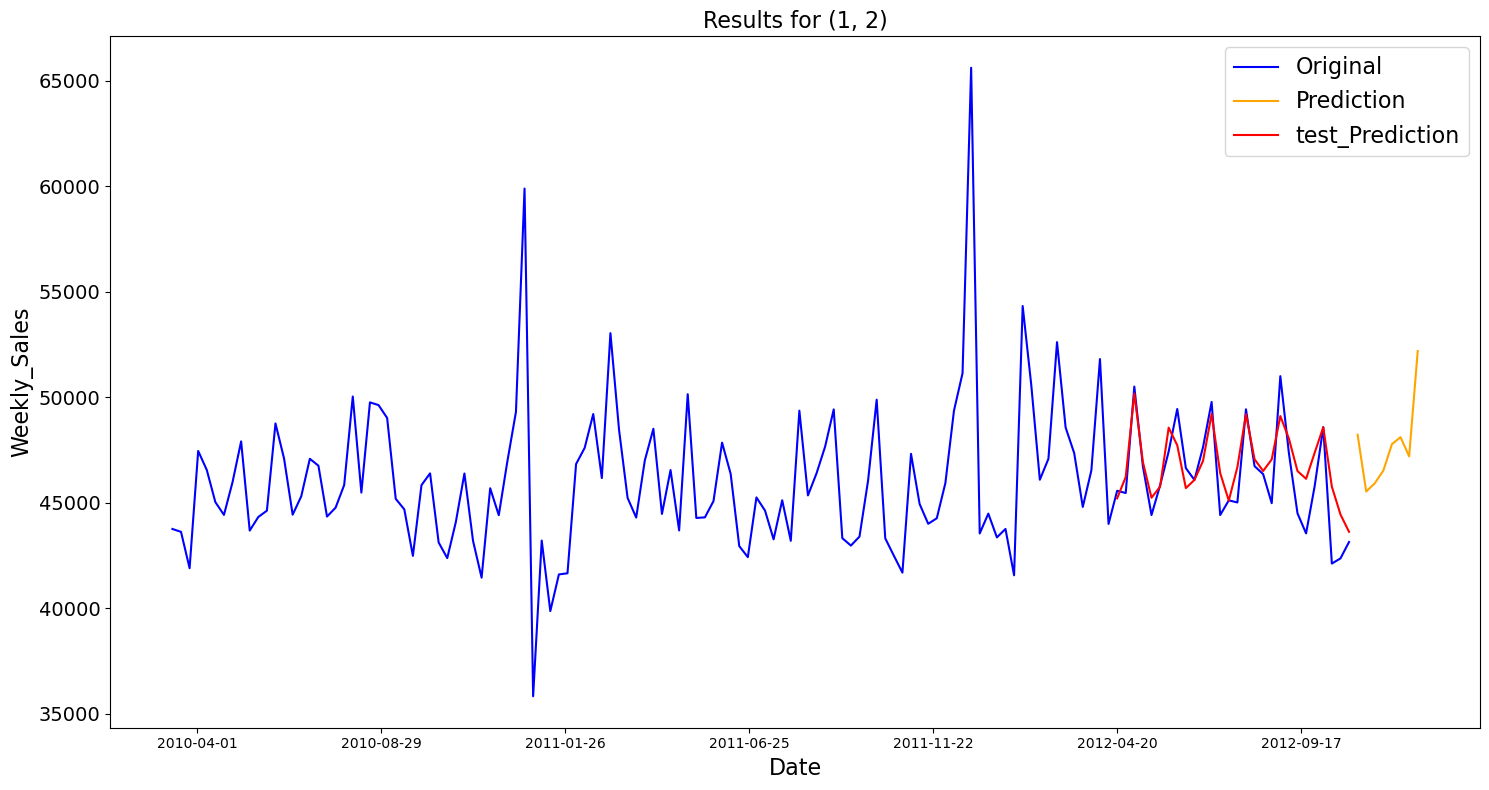

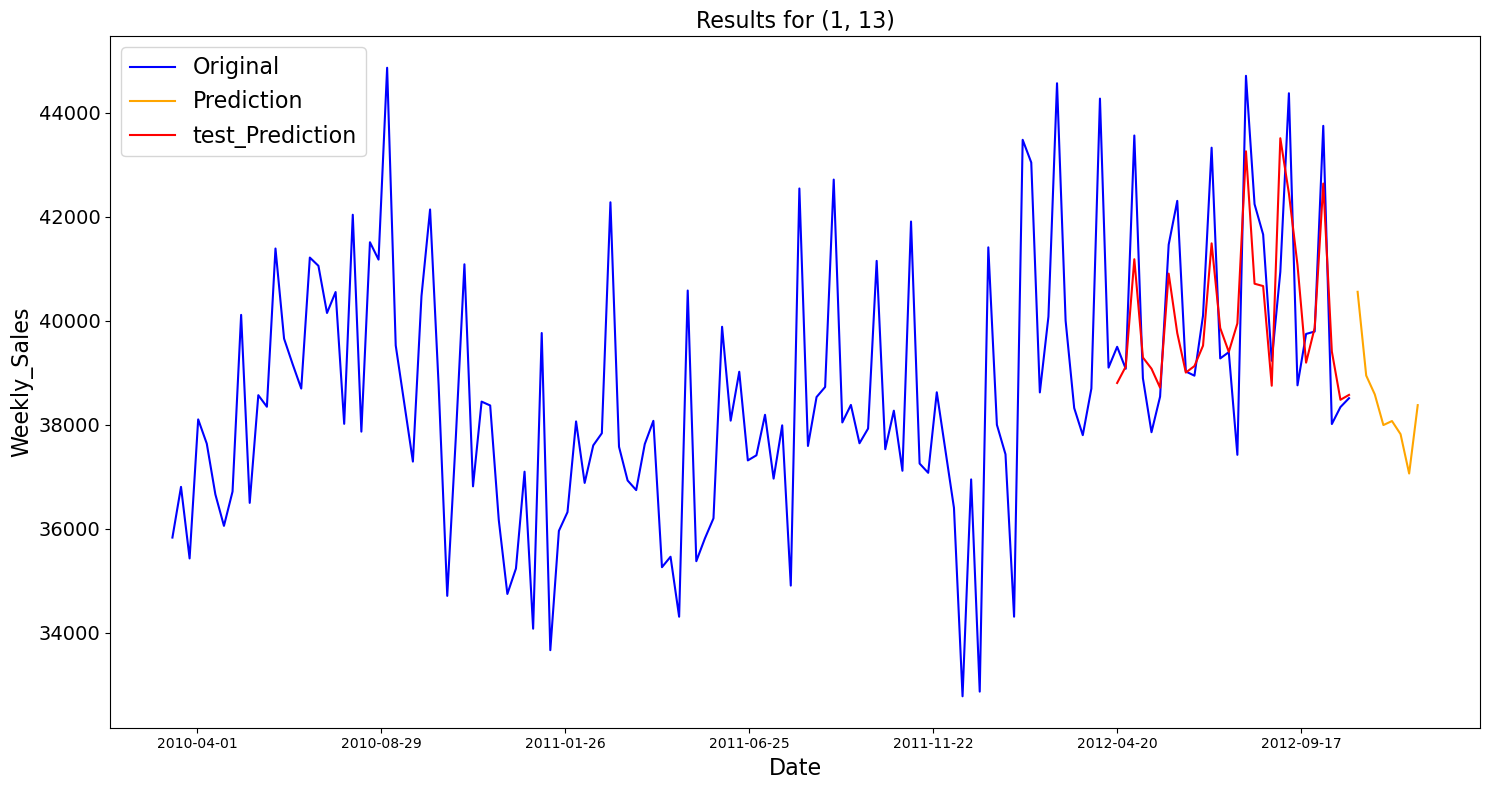

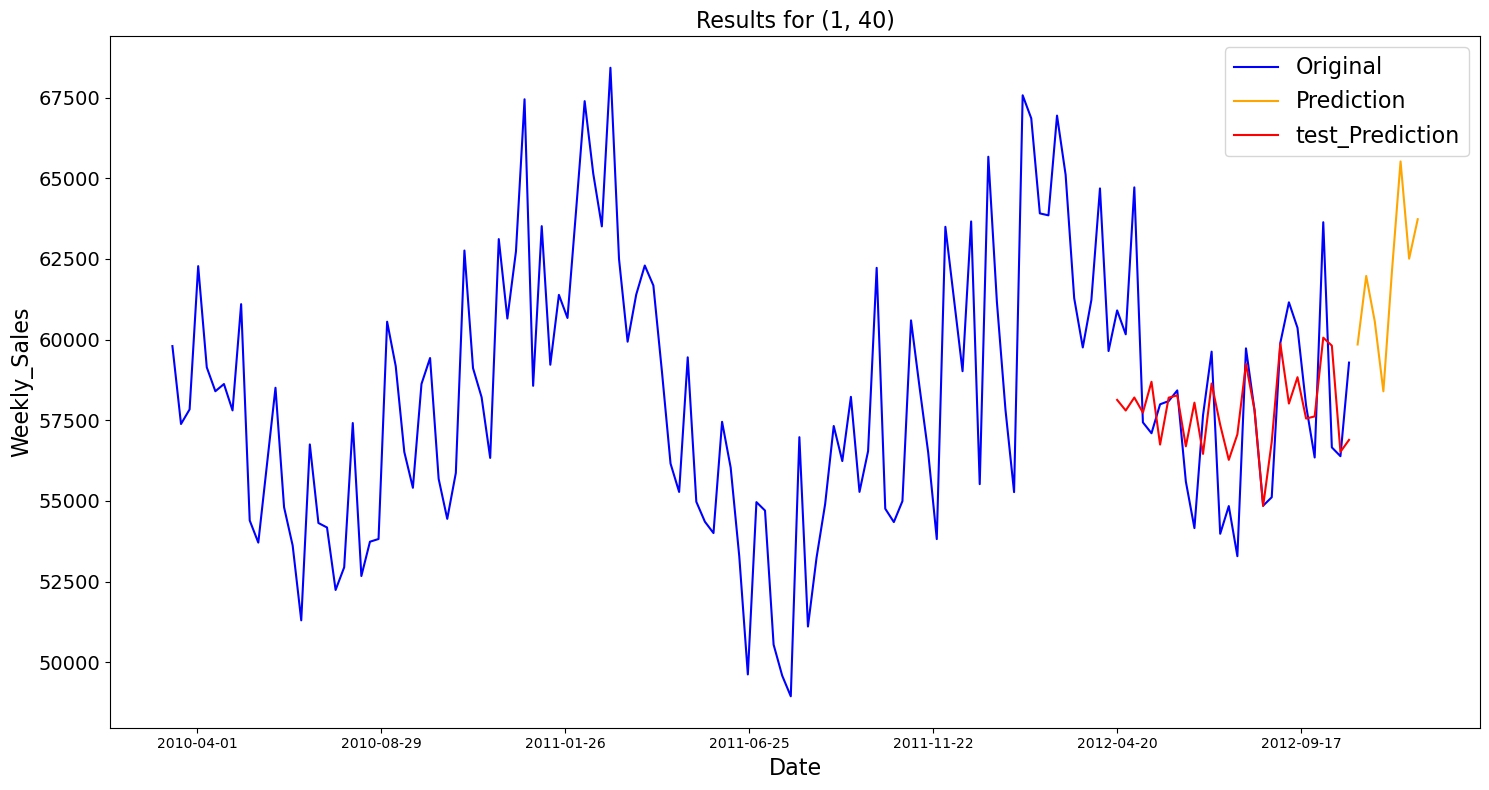

In [73]:
#create the results plot including orginal values, predicted value for test/validation dataset, and predictions for unseen data(8 weeks)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



for key in top_index:
    original_results = loaded_models_dict[key]['original_value']
    predicted_results = loaded_models_dict[key]['predicted_value']
    test_results = loaded_models_dict[key]['val_results']
    
    # Create plots
    # Create a new figure with custom dimensions
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(original_results['Date'], original_results['original_value'], label='Original', color='blue')
    ax.plot(predicted_results['Date'], predicted_results['predicted_value'], label='Prediction', color='orange')
    ax.plot(test_results['Date'], test_results['predicted_value'], label='test_Prediction', color='red')

    # Title and labels
    ax.set_title(f"Results for {key}",fontsize=16)
    ax.set_xlabel('Date',fontsize=16)
    ax.set_ylabel('Weekly_Sales',fontsize=16)

    # Rotate x-axis labels and set font size
    #plt.xticks(rotation=45,fontsize=14)
    plt.yticks(fontsize=14)
    # Prune 'both' ends of the x-axis
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='both'))

    # Add legend
    ax.legend(fontsize=16)

    # Auto-adjust layout to prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

In [74]:
def residual_plot(residuals,key):
    #autocorrelation plot of residuals for test dataset
    plot_acf(residuals,lags=25)
    plt.title(f'ACF plot of residuals for store/dept{key}')

    plt.figure(figsize=(8, 4))
    plt.plot(residuals, marker='o')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    plt.show()

# Histogram of residuals
    plt.figure(figsize=(8, 4))
    plt.hist(residuals, bins=10)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Residuals for store/dept {key}')
    plt.show()

# QQ plot of residuals
    from statsmodels.graphics.gofplots import qqplot
    plt.figure(figsize=(8, 4))
    qqplot(residuals, line='s')
    plt.title(f'QQ Plot of Residuals for store/dept{key}')
    plt.show()

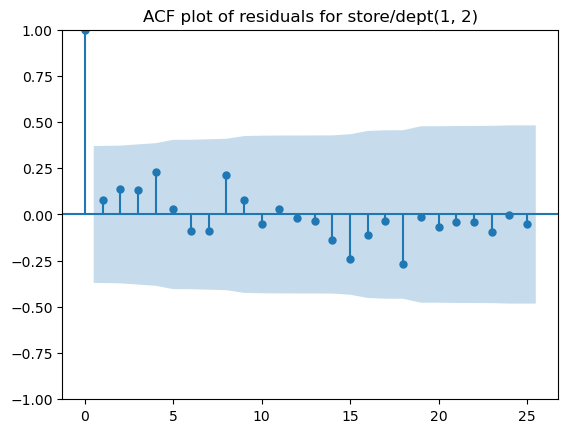

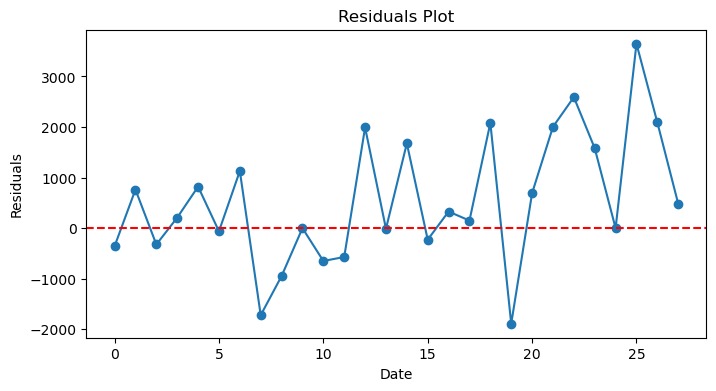

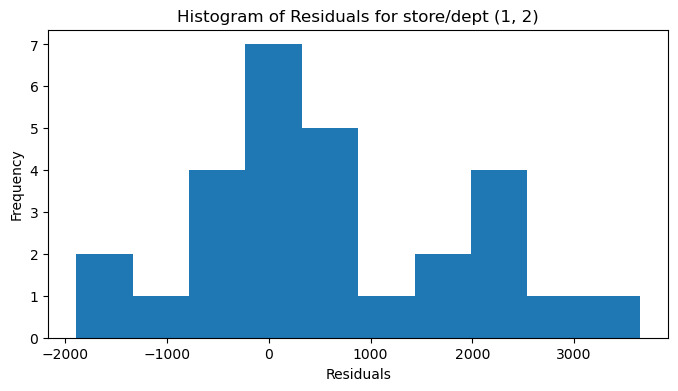

<Figure size 800x400 with 0 Axes>

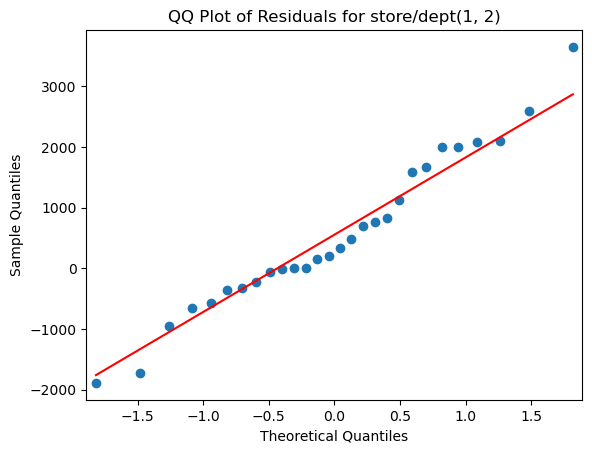

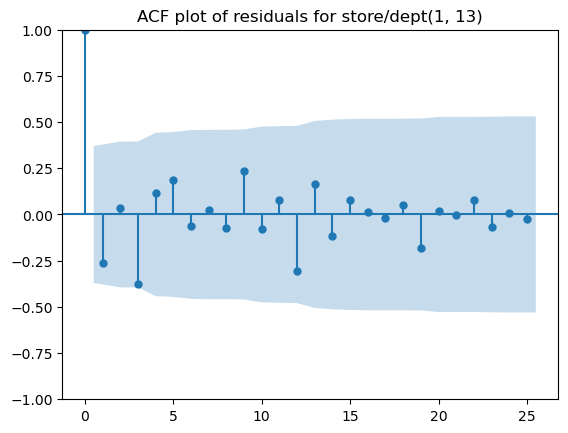

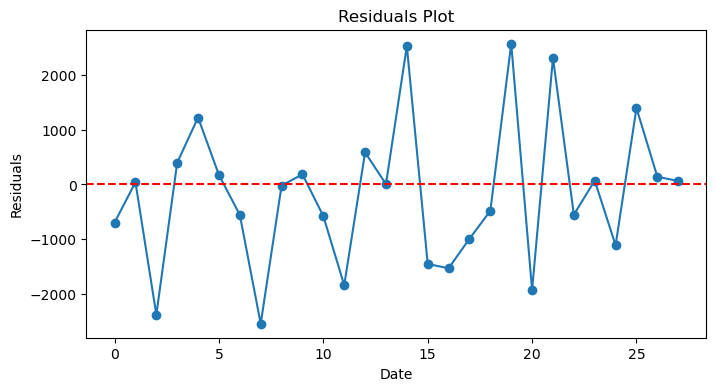

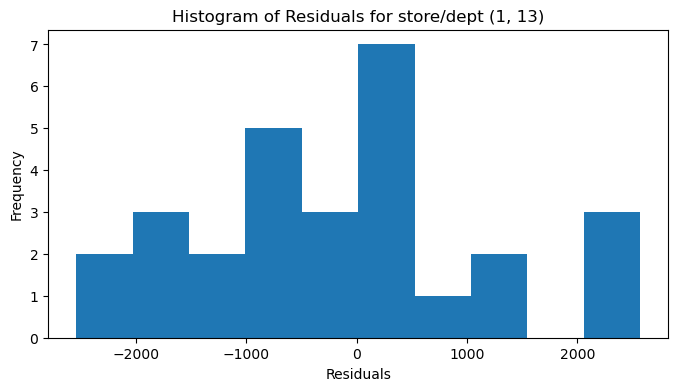

<Figure size 800x400 with 0 Axes>

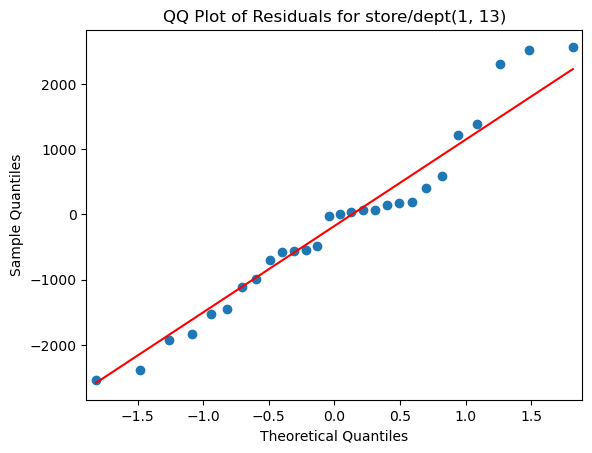

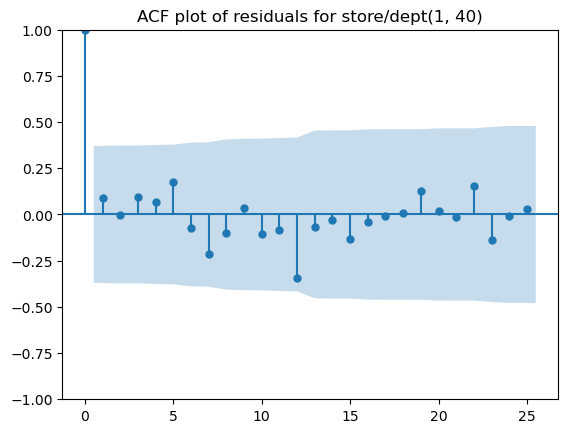

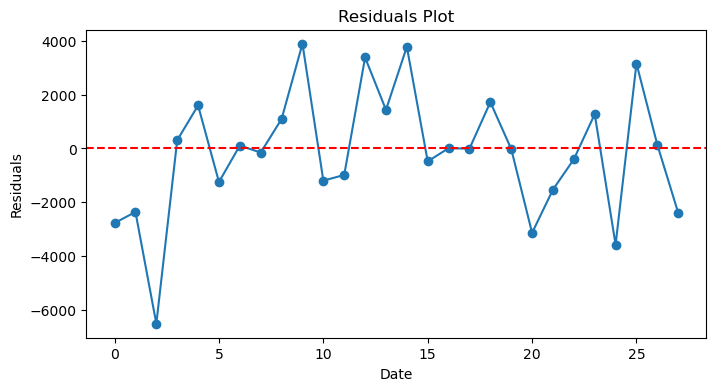

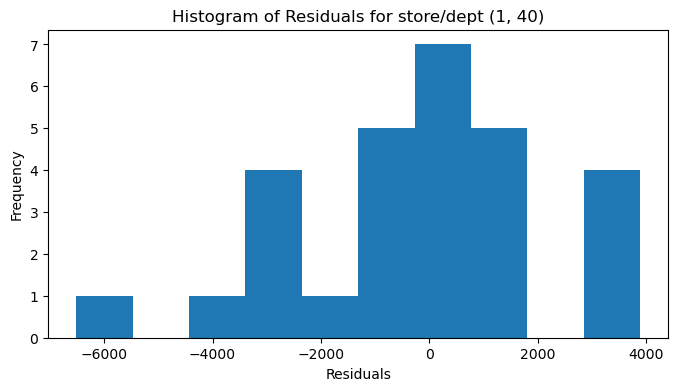

<Figure size 800x400 with 0 Axes>

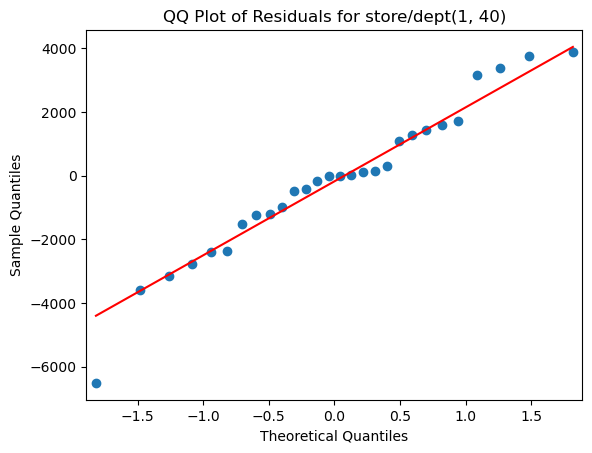

In [75]:
#create residual plots for validation dataset
for key in top_index:
    residuals = loaded_models_dict[key]['val_residual']
    residual_plot(residuals,key)

In [76]:
lowest_index=[(1,71),(1,36),(1,58)]

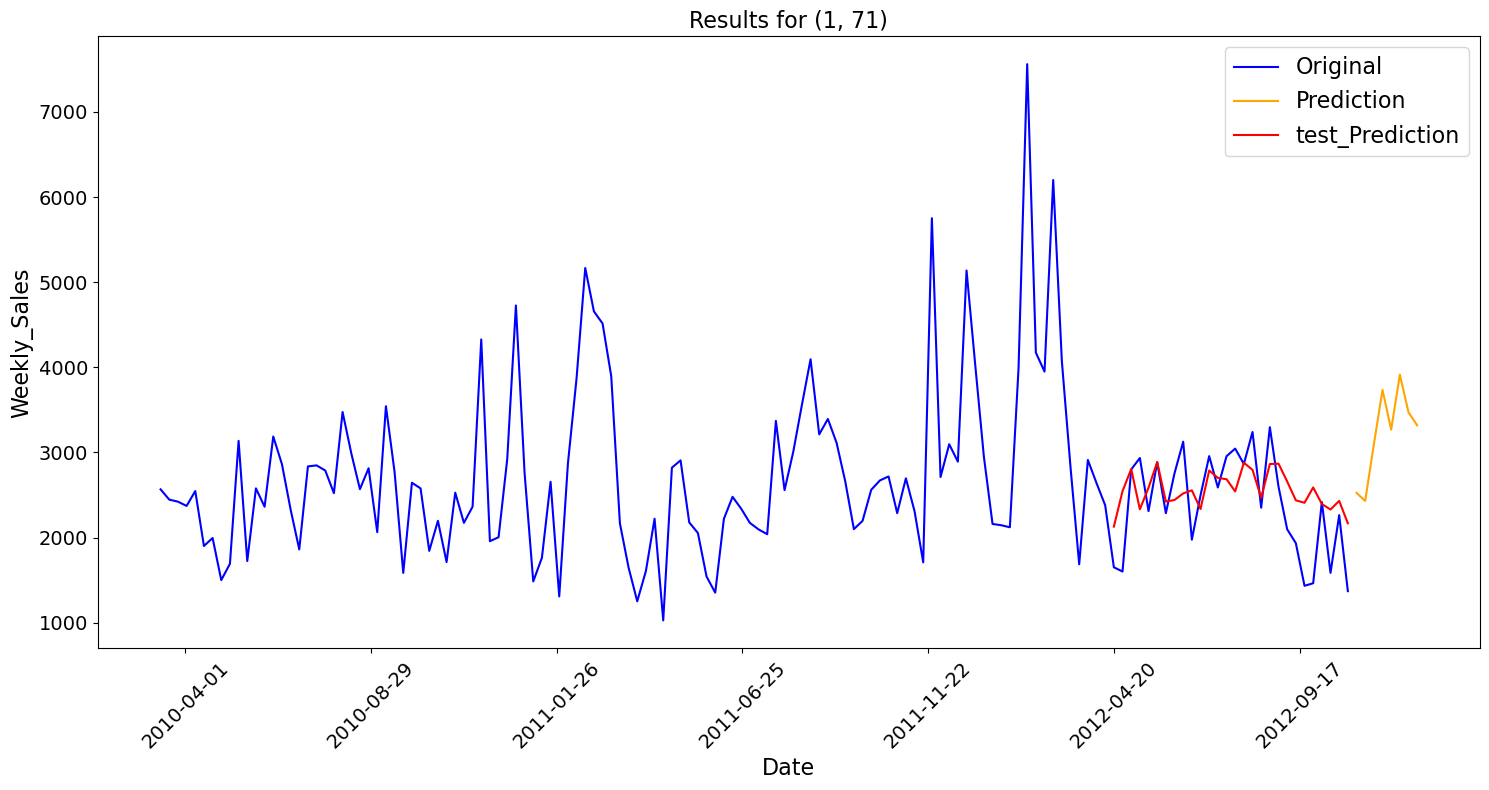

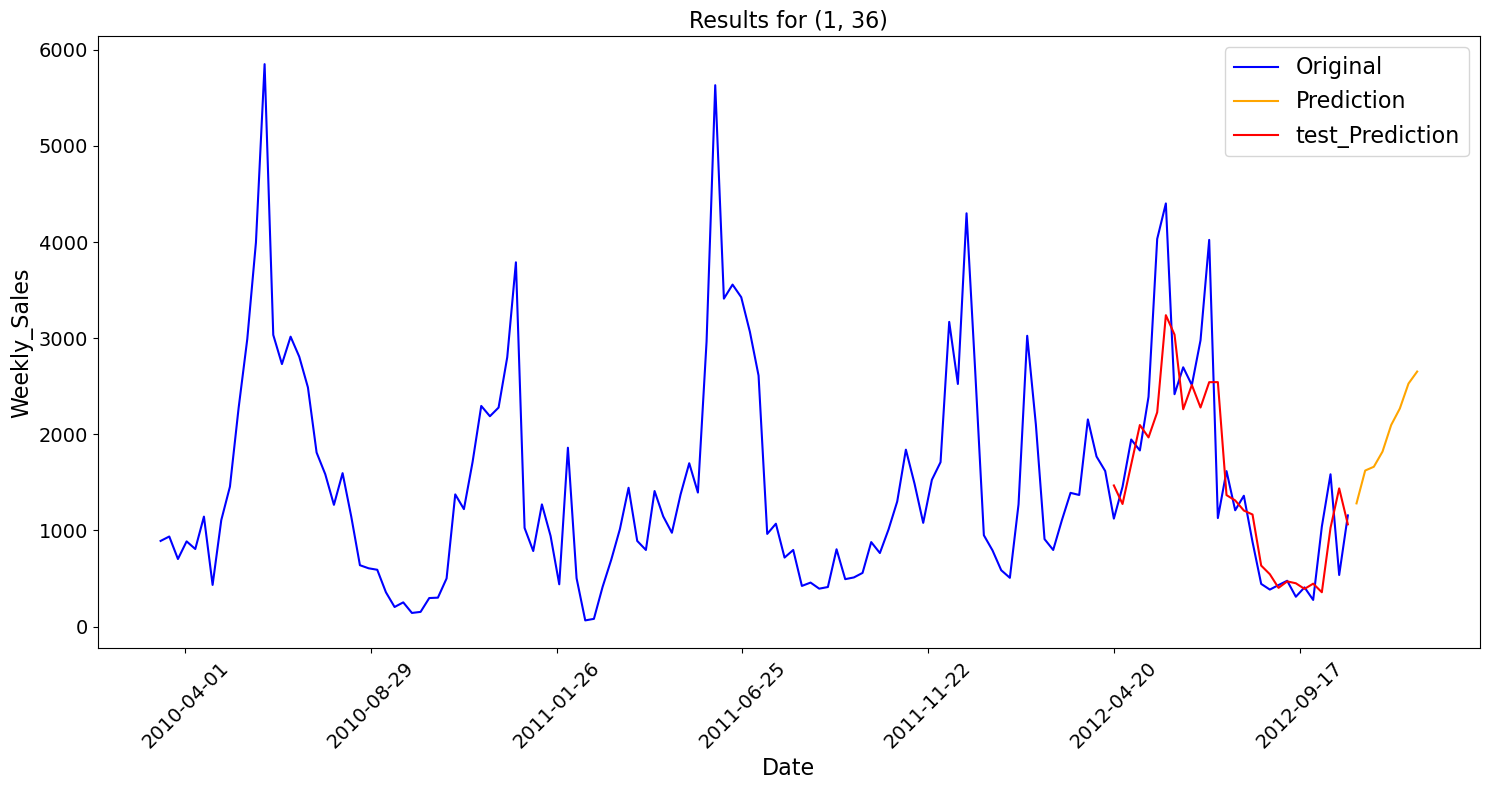

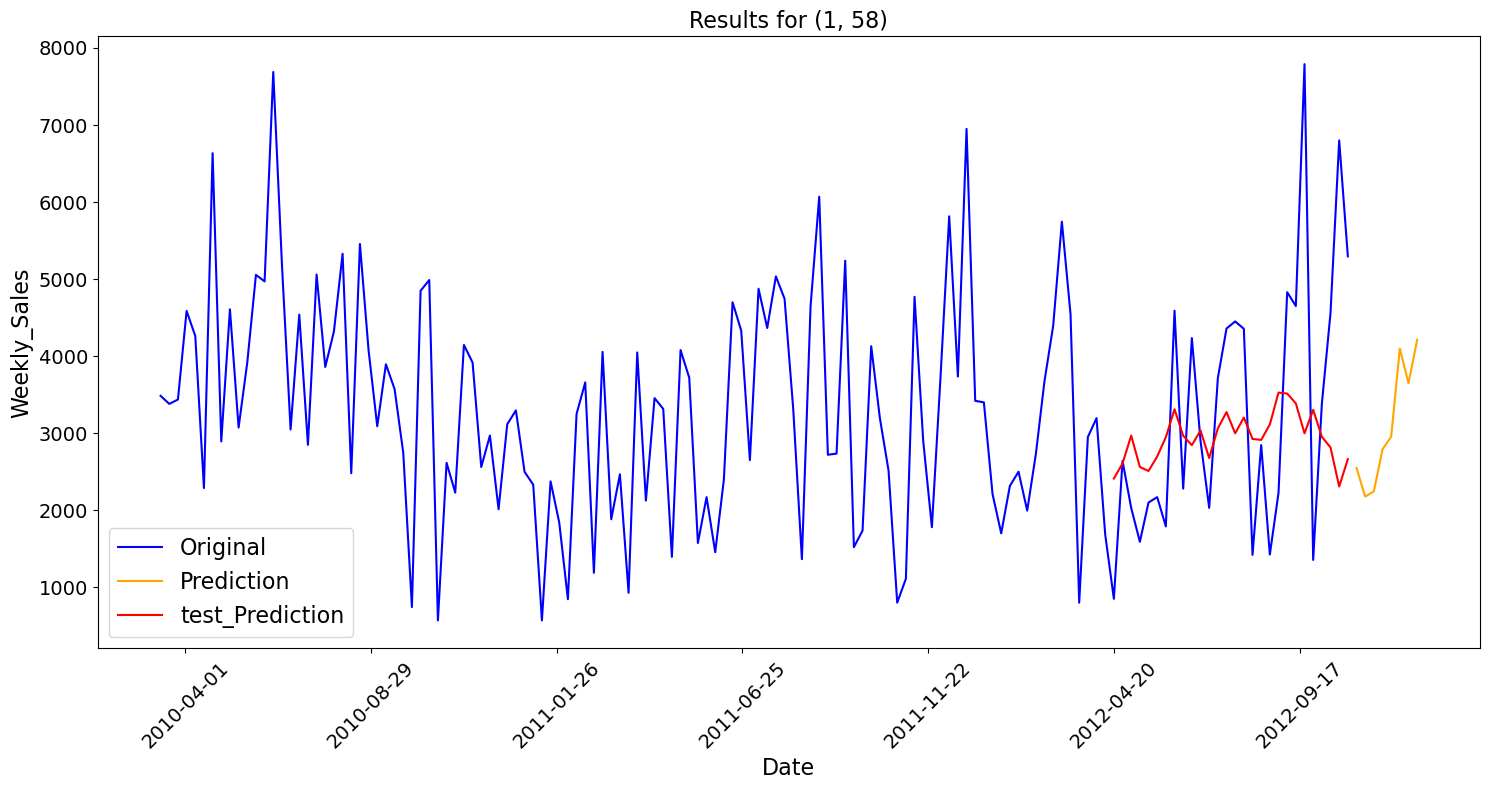

In [79]:
for key in lowest_index:
    original_results = loaded_models_dict[key]['original_value']
    predicted_results = loaded_models_dict[key]['predicted_value']
    test_results = loaded_models_dict[key]['val_results']

    # Create plots
    # Create a new figure with custom dimensions
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(original_results['Date'], original_results['original_value'], label='Original', color='blue')
    ax.plot(predicted_results['Date'], predicted_results['predicted_value'], label='Prediction', color='orange')
    ax.plot(test_results['Date'], test_results['predicted_value'], label='test_Prediction', color='red')

    # Title and labels
    ax.set_title(f"Results for {key}",fontsize=16)
    ax.set_xlabel('Date',fontsize=16)
    ax.set_ylabel('Weekly_Sales',fontsize=16)

    # Rotate x-axis labels and set font size
    plt.xticks(rotation=45,fontsize=14)
    plt.yticks(fontsize=14)
    # Prune 'both' ends of the x-axis
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='both'))

    # Add legend
    ax.legend(fontsize=16)

    # Auto-adjust layout to prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

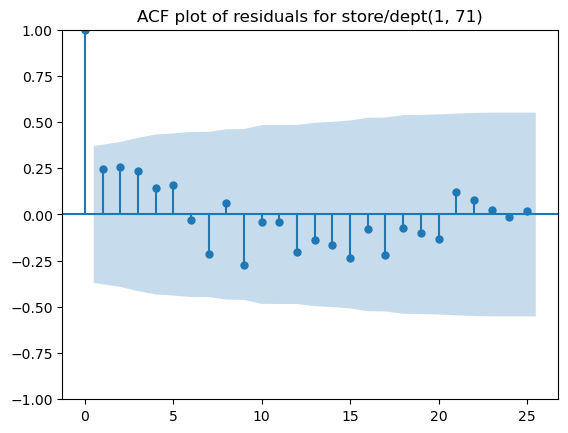

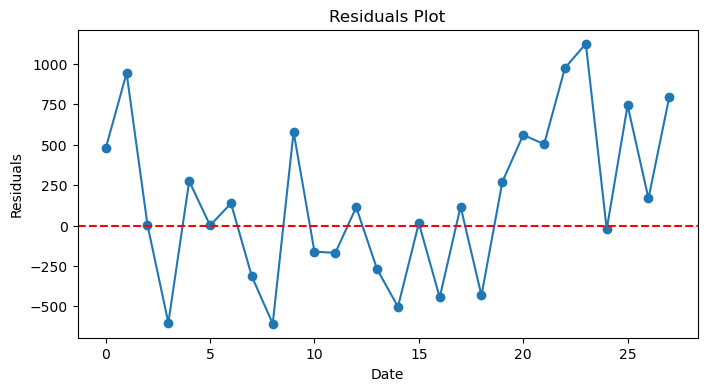

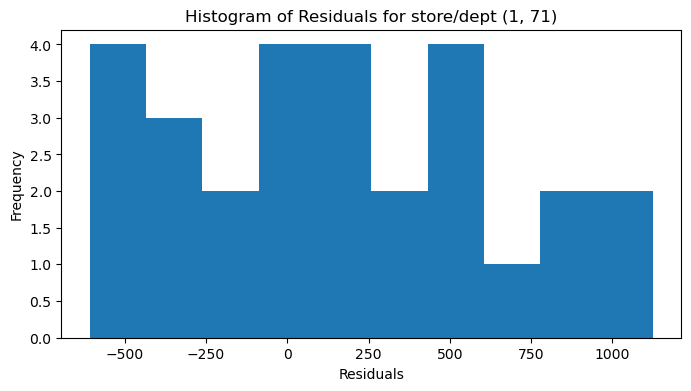

<Figure size 800x400 with 0 Axes>

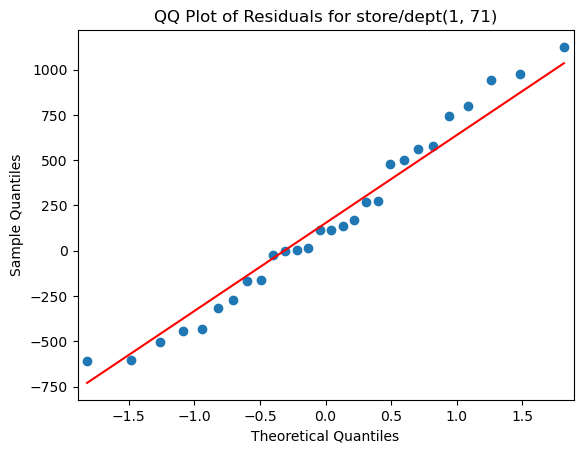

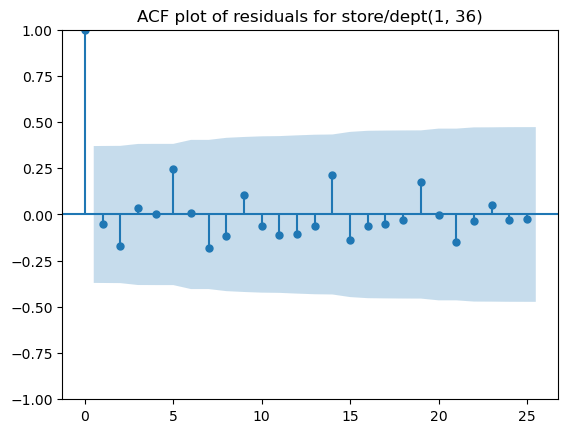

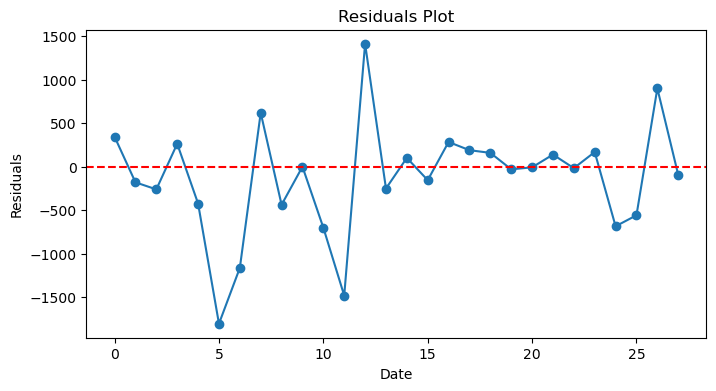

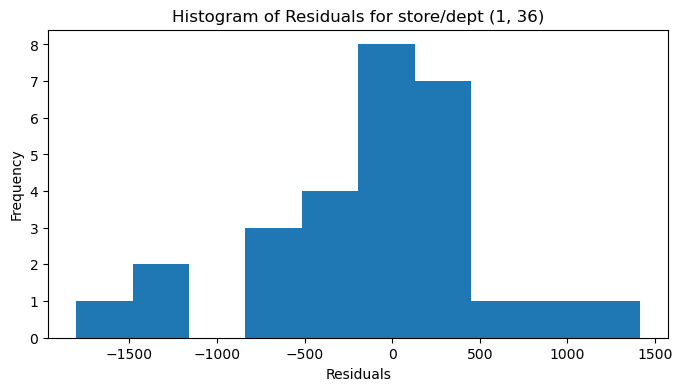

<Figure size 800x400 with 0 Axes>

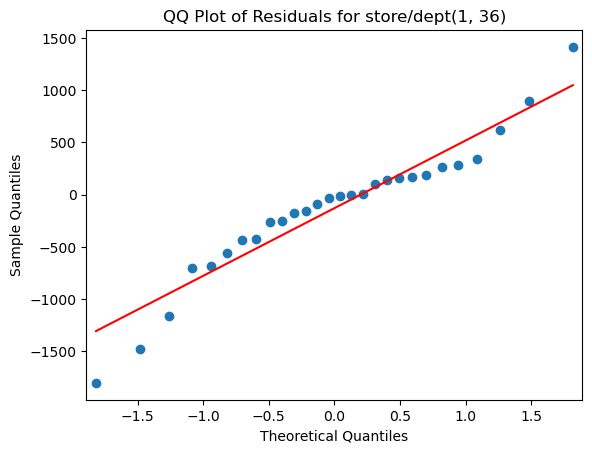

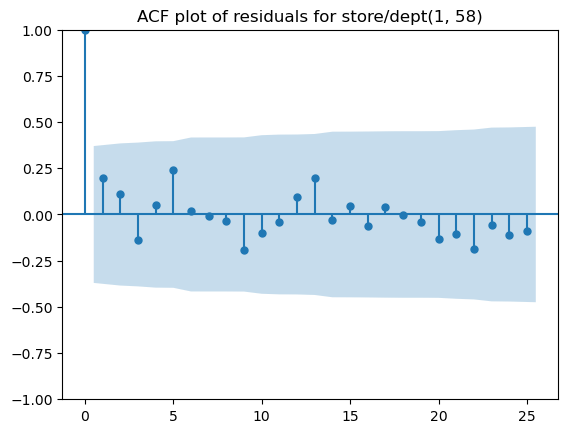

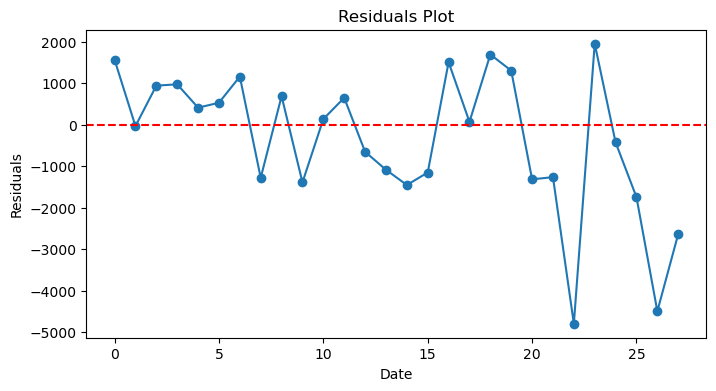

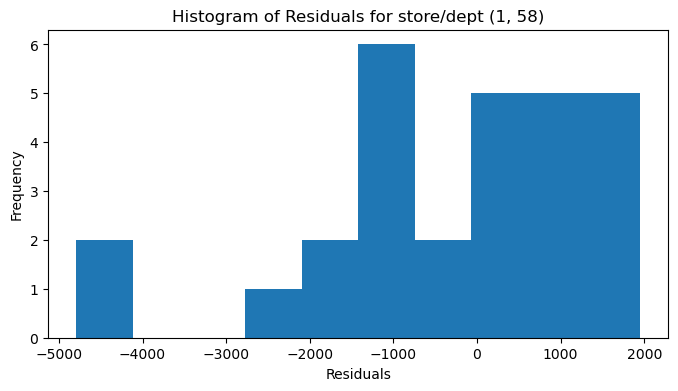

<Figure size 800x400 with 0 Axes>

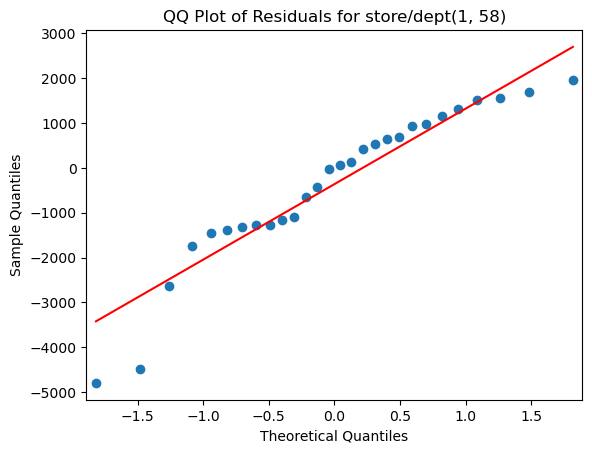

In [80]:
for key in lowest_index:
    residuals = loaded_models_dict[key]['val_residual']
    residual_plot(residuals,key)

Based on autoML, the optimal models for all the store/dept are ensemble, top three store/dept with lowest MAPE are (1,2),(1,13),(1,40). the lowest ranking store/dept with highest MAPE are (1,71),(1,36),(1,58)